<a href="https://colab.research.google.com/github/tomoaki-575/hangman/blob/master/%E6%89%8B%E6%9B%B8%E3%81%8D%E6%95%B0%E5%AD%97%E5%85%A5%E5%8A%9B%E3%83%BB%E4%BA%88%E6%B8%ACGUI%E3%82%A2%E3%83%95%E3%82%9A%E3%83%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  手書き数字入力・識別アプリケーションの作成
　MNISTの手書き数字のデータセットを用いて、デープラーニングにより汎化性能が高い学習済みモデルを作成、その学習済みモデルを利用した手書き数字入力・予測GUIアプリケーションを作成した。MLPでは98.3\~98.5％程度、CNNでは99.0\~99.1％程度、VGG-likeでは99.5\~99.6%程度のvalidation accuracyが得られた。数字入力・予測GUIアプリケーションにはVGG-likeの学習済みモデルを利用し、入力数字の位置+サイズ補正することで数字の認識・予測精度を向上させることに成功した。

<a name="index1"></a>
#### <a href="#index1">【学習済みモデルの作成】</a>
[１. MLP ドロップアウトなし](#anchor1)  
[（１）1層 MLP](#anchor2)  
[（２）2層 MLP](#anchor3)  
[（３）3層 MLP](#anchor4)  
[（４）5層 MLP](#anchor5)  
[（５）層の深さの違いによるMLPの結果比較](#anchor6)  
<br>
[２. MLP ドロップアウトあり](#drop1)  
[（１）1層 MLP-dropout](#drop2)  
[（２）2層 MLP-dropout](#drop3)  
[（３）3層 MLP-dropout](#drop4)  
[（４）5層 MLP-dropout](#drop5)  
[（５）層の深さの違いによるMLP-dropoutの結果比較](#drop6)  
<br>
[３. MLP BatchNormalization](#BatchNormalization1)  
[（１）1層 MLP-BN](#BatchNormalization2)  
[（２）2層 MLP-BN](#BatchNormalization3)  
[（３）3層 MLP-BN](#BatchNormalization4)  
[（４）5層 MLP-BN](#BatchNormalization5)  
[（５）層の深さの違いによるMLP-BNの結果比較](#BatchNormalization6)  
[（６）各MLPの結果比較](#BatchNormalization7)  
<br>
[４. CNN](#cnn1)  
[（１）CNN 32](#cnn2)  
[（２）CNN 64](#cnn3)  
[（３）CNN 128](#cnn4)  
[（４）CNN 256](#cnn5)  
[（５）Batch sizeの違いによるCNN結果比較](#cnn6)  
<br>
[５. VGG-like](#vgg1)  
[（１）VGG-like 32](#vgg2)  
[（２）VGG-like 64](#vgg3)  
[（３）VGG-like 128](#vgg4)  
[（４）VGG-like 256](#vgg5)  
[（５）Batch sizeの違いによるVGG-like結果比較](#vgg6)  
<br>
以上のモデルを作成して学習させた。このとき、それぞれのアルゴリズムで隠れ層数、またはエポック数を変更させ汎化性能を比較した。
<br>
<br>

<a name="index2"></a>
#### <a href="#index2">【TkinterによるGUIアプリケーション作成】</a>
[６. 手書き数字入力・予測GUIアプリケーションの作成](#gui1)  
[（１）補正なし](#gui2)  
[（２）位置＋サイズ補正あり](#gui3)  
[（３）補正失敗](#gui4)  
<br>

以下の条件下で環境で作成・実行した。\
+++++++++++++++++++++++++++\
intel Core i7-7700\
CentOS 7.8.2003

python == 3.6.10\
jupyter == 1.0.0\
tensorflow-cpu == 2.2.0\
Keras == 2.4.3\
numpy == 1.18.5\
pandas == 0.24.2\
scipy == 1.4.1\
matplotlib == 3.3.3\
Pillow == 8.0.1\
+++++++++++++++++++++++++++

＊１ google colab上ではアプリを起動できません。Tkinterがブラウザ上で起動できないため、上記のpython環境をPCに構築しすることで起動できます。その際、同ディレクトリ上に、本コードと学習済みデータ”numeral_VGG_like256_model.h5”が存在していること確認してください。

＊２　本GUIアプリケーションは、「カラー図解　RaspberryPiではじめる機械学習　基礎からディープラーニングまで」初版、金丸 隆志（著）、講談社（2018）を参考に作成した。
URL：https://gendai.ismedia.jp/list/books/bluebacks/9784065020524

<br>

In [ ]:
# google colab上でデータを保存や読み込みをする準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# データを保存や読み込みをするフォルダーを指定
%cd /content/drive/My Drive/手書き数字識別アプリ

/content/drive/My Drive/手書き数字識別アプリ


### [<div style="text-align: right;">↑</div>](#index1)
<a name="anchor1"></a>
## <a href="#anchor1">1. MLP-ドロップアウトなし</a> 
<a name="anchor2"></a>
### <a href="#anchor2">(1) 1層 MLP</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP1 = keras.models.Sequential()
model_MLP1.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP1.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP1 = model_MLP1.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=1, 
                      validation_data=(X_test, y_test))

# モデルを保存
model_MLP1.save('numeral_mlp1_model.h5')

# モデルを評価
score_MLP1 = model_MLP1.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP1[1], 'loss =', score_MLP1[0])

Epoch 1/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2659 - accuracy: 0.9245 - val_loss: 0.1281 - val_accuracy: 0.9641
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1077 - accuracy: 0.9686 - val_loss: 0.0973 - val_accuracy: 0.9704
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9790 - val_loss: 0.0809 - val_accuracy: 0.9771
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0512 - accuracy: 0.9851 - val_loss: 0.0703 - val_accuracy: 0.9775
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0387 - accuracy: 0.9886 - val_loss: 0.0642 - val_accuracy: 0.9797
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0280 - accuracy: 0.9921 - val_loss: 0.0634 - val_accuracy: 0.9810
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.0701 - val_accuracy: 0.9781
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________

正解率 = 0.9837999939918518 loss = 0.09112019836902618


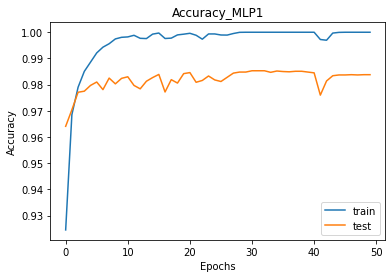

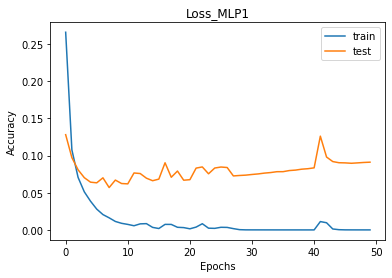

In [ ]:
# モデルの要約を表示
model_MLP1.summary()

# モデルを評価
print('\n正解率 =', score_MLP1[1], 'loss =', score_MLP1[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1.history['accuracy'])
plt.plot(hist_MLP1.history['val_accuracy'])
plt.title('Accuracy_MLP1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1.history['loss'])
plt.plot(hist_MLP1.history['val_loss'])
plt.title('Loss_MLP1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP2 = keras.models.Sequential()
model_MLP2.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP2.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP2 = model_MLP2.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=1, 
                      validation_data=(X_test, y_test))

# モデルを保存
model_MLP2.save('numeral_mlp2_model.h5')

# モデルを評価
score_MLP2 = model_MLP2.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP2[1], 'loss =', score_MLP2[0])

Epoch 1/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2645 - accuracy: 0.9255 - val_loss: 0.1445 - val_accuracy: 0.9563
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1079 - accuracy: 0.9692 - val_loss: 0.0921 - val_accuracy: 0.9722
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0699 - accuracy: 0.9793 - val_loss: 0.0782 - val_accuracy: 0.9758
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0500 - accuracy: 0.9853 - val_loss: 0.0733 - val_accuracy: 0.9756
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.0632 - val_accuracy: 0.9802
Epoch 6/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0273 - accuracy: 0.9924 - val_loss: 0.0653 - val_accuracy: 0.9808
Epoch 7/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.9945 - val_loss: 0.0622 - val_accuracy: 0.9808
Epoch 

### [<div style="text-align: right;">↑</div>](#index1)
<a name="anchor3"></a>
### <a href="#anchor3">(2) 2層 MLP</a> 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________

正解率 = 0.9832000136375427 loss = 0.08654307574033737


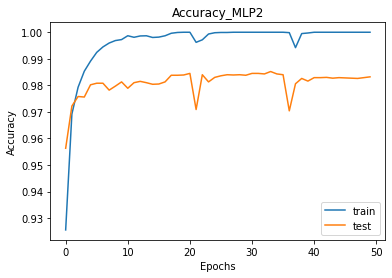

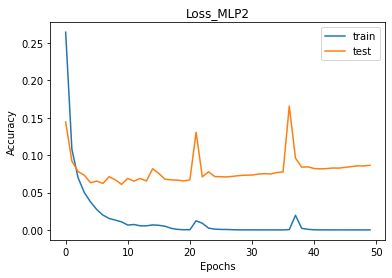

In [ ]:
# モデルの要約を表示
model_MLP2.summary()

# モデルを評価
print('\n正解率 =', score_MLP2[1], 'loss =', score_MLP2[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP2.history['accuracy'])
plt.plot(hist_MLP2.history['val_accuracy'])
plt.title('Accuracy_MLP2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP2.history['loss'])
plt.plot(hist_MLP2.history['val_loss'])
plt.title('Loss_MLP2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="anchor4"></a>
### <a href="#anchor4">(3) 3層 MLP</a>

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP3 = keras.models.Sequential()
model_MLP3.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP3.add(Dense(512, activation='relu'))
model_MLP3.add(Dense(512, activation='relu'))
model_MLP3.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP3 = model_MLP3.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=1, 
                      validation_data=(X_test, y_test))

# モデルを保存
model_MLP3.save('numeral_mlp3_model.h5')

# モデルを評価
score_MLP3 = model_MLP3.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP3[1], 'loss =', score_MLP3[0])

Epoch 1/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2127 - accuracy: 0.9366 - val_loss: 0.1166 - val_accuracy: 0.9612
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0810 - accuracy: 0.9748 - val_loss: 0.0914 - val_accuracy: 0.9732
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0535 - accuracy: 0.9827 - val_loss: 0.0781 - val_accuracy: 0.9763
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0386 - accuracy: 0.9880 - val_loss: 0.0692 - val_accuracy: 0.9803
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0340 - accuracy: 0.9891 - val_loss: 0.0731 - val_accuracy: 0.9802
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0960 - val_accuracy: 0.9725
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0749 - val_accuracy: 0.9815
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________

正解率 = 0.9836000204086304 loss = 0.13720962405204773


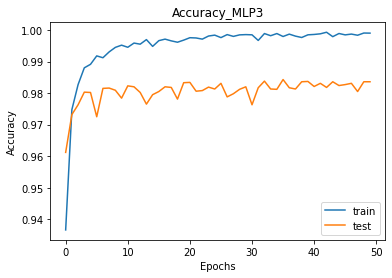

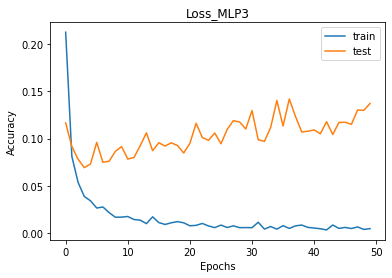

In [ ]:
# モデルの要約を表示
model_MLP3.summary()

# モデルを評価
print('\n正解率 =', score_MLP3[1], 'loss =', score_MLP3[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP3.history['accuracy'])
plt.plot(hist_MLP3.history['val_accuracy'])
plt.title('Accuracy_MLP3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP3.history['loss'])
plt.plot(hist_MLP3.history['val_loss'])
plt.title('Loss_MLP3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="anchor5"></a>
### <a href="#anchor5">(2) 5層 MLP</a>

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP5 = keras.models.Sequential()
model_MLP5.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP5.add(Dense(512, activation='relu'))
model_MLP5.add(Dense(512, activation='relu'))
model_MLP5.add(Dense(512, activation='relu'))
model_MLP5.add(Dense(512, activation='relu'))
model_MLP5.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP5= model_MLP5.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=1, 
                      validation_data=(X_test, y_test))

# モデルを保存
model_MLP5.save('numeral_mlp5_model.h5')

# モデルを評価
score_MLP5 = model_MLP5.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP5[1], 'loss =', score_MLP5[0])

Epoch 1/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2239 - accuracy: 0.9325 - val_loss: 0.1194 - val_accuracy: 0.9648
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0962 - accuracy: 0.9713 - val_loss: 0.1089 - val_accuracy: 0.9650
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0657 - accuracy: 0.9800 - val_loss: 0.0856 - val_accuracy: 0.9757
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0547 - accuracy: 0.9836 - val_loss: 0.0814 - val_accuracy: 0.9765
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0413 - accuracy: 0.9873 - val_loss: 0.0784 - val_accuracy: 0.9808
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0383 - accuracy: 0.9887 - val_loss: 0.1084 - val_accuracy: 0.9692
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0325 - accuracy: 0.9905 - val_loss: 0.0891 - val_accuracy: 0.9782
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 1,457,674
Trainable params: 1,457,674
Non-trainable params: 0
______________________________________________

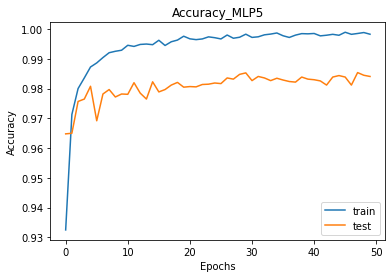

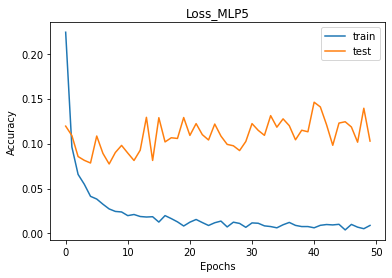

In [ ]:
# モデルの要約を表示
model_MLP5.summary()

# モデルを評価
print('\n正解率 =', score_MLP5[1], 'loss =', score_MLP5[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP5.history['accuracy'])
plt.plot(hist_MLP5.history['val_accuracy'])
plt.title('Accuracy_MLP5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP5.history['loss'])
plt.plot(hist_MLP5.history['val_loss'])
plt.title('Loss_MLP5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="anchor6"></a>
### <a href="#anchor6">(5) 層の深さの違いによるMLPの結果比較</a>   
  層を深くしてもtest_Accuracyにほぼ変化がなく、test_Lossのベースラインが高くなる傾向が見られた。1,2層のMLPでは突発的なtest_Accuracyの低下とtest_Lossの上昇が確認されたが、3,5層のMLPでは見られなくなった。よって、MLPを利用したMNISTのデータの学習では、単に層を深くしても汎化性能は向上しないことが示された。


MLP1 正解率 = 0.9837999939918518 loss = 0.09112019836902618

MLP2 正解率 = 0.9832000136375427 loss = 0.08654307574033737

MLP3 正解率 = 0.9836000204086304 loss = 0.13720962405204773

MLP5 正解率 = 0.9840999841690063 loss = 0.1027676984667778


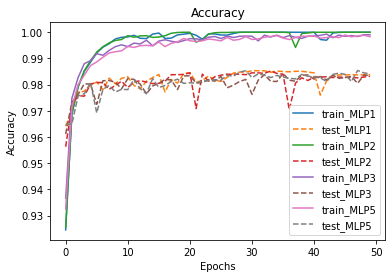

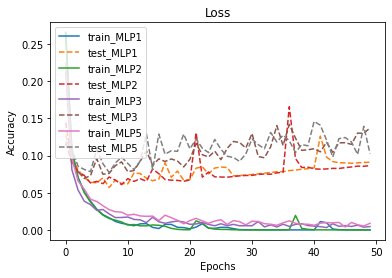

In [ ]:
# モデルを評価
print('\nMLP1', '正解率 =', score_MLP1[1], 'loss =', score_MLP1[0])
print('\nMLP2', '正解率 =', score_MLP2[1], 'loss =', score_MLP2[0])
print('\nMLP3', '正解率 =', score_MLP3[1], 'loss =', score_MLP3[0])
print('\nMLP5', '正解率 =', score_MLP5[1], 'loss =', score_MLP5[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1.history['accuracy'])
plt.plot(hist_MLP1.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP2.history['accuracy'])
plt.plot(hist_MLP2.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP3.history['accuracy'])
plt.plot(hist_MLP3.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP5.history['accuracy'])
plt.plot(hist_MLP5.history['val_accuracy'], linestyle="dashed")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1', 'test_MLP1', 
            'train_MLP2', 'test_MLP2',
            'train_MLP3', 'test_MLP3', 
            'train_MLP5', 'test_MLP5',], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1.history['loss'])
plt.plot(hist_MLP1.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP2.history['loss'])
plt.plot(hist_MLP2.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP3.history['loss'])
plt.plot(hist_MLP3.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP5.history['loss'])
plt.plot(hist_MLP5.history['val_loss'], linestyle="dashed")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1', 'test_MLP1', 
            'train_MLP2', 'test_MLP2',
            'train_MLP3', 'test_MLP3', 
            'train_MLP5', 'test_MLP5',], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="drop1"></a>
## <a href="#drop1">2. MLP_ドロップアウトあり</a> 
<a name="drop2"></a>
### <a href="#drop2">(1) 1層 MLP_dropout</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP1_DropOut = keras.models.Sequential()
model_MLP1_DropOut.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP1_DropOut.add(Dropout(0.2))
model_MLP1_DropOut.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP1_DropOut.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP1_DropOut = model_MLP1_DropOut.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP1_DropOut.save('numeral_mlp1_dropout_model.h5')

# モデルを評価
score_MLP1_DropOut = model_MLP1_DropOut.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP1_DropOut[1], 'loss =', score_MLP1_DropOut[0])

Epoch 1/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2820 - accuracy: 0.9194 - val_loss: 0.1324 - val_accuracy: 0.9597
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1220 - accuracy: 0.9642 - val_loss: 0.0977 - val_accuracy: 0.9689
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.0794 - val_accuracy: 0.9764
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0621 - accuracy: 0.9809 - val_loss: 0.0696 - val_accuracy: 0.9791
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0501 - accuracy: 0.9847 - val_loss: 0.0671 - val_accuracy: 0.9786
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0411 - accuracy: 0.9879 - val_loss: 0.0626 - val_accuracy: 0.9806
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0346 - accuracy: 0.9892 - val_loss: 0.0605 - val_accuracy: 0.9810
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________

正解率 = 0.9836000204086304 loss = 0.09323955327272415


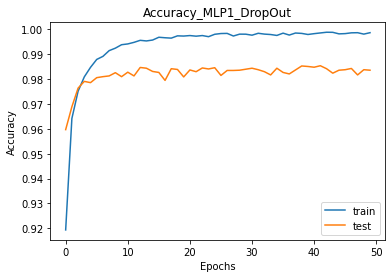

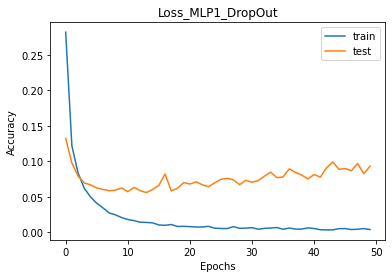

In [ ]:
# モデルの要約を表示
model_MLP1_DropOut.summary()

# モデルを評価
print('\n正解率 =', score_MLP1_DropOut[1], 'loss =', score_MLP1_DropOut[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1_DropOut.history['accuracy'])
plt.plot(hist_MLP1_DropOut.history['val_accuracy'])
plt.title('Accuracy_MLP1_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1_DropOut.history['loss'])
plt.plot(hist_MLP1_DropOut.history['val_loss'])
plt.title('Loss_MLP1_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1) 
<a name="drop3"></a>
### <a href="#drop3">(1) 2層 MLP_dropout</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP2_DropOut = keras.models.Sequential()
model_MLP2_DropOut.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP2_DropOut.add(Dropout(0.2))
model_MLP2_DropOut.add(Dense(512, activation='relu'))
model_MLP2_DropOut.add(Dropout(0.2))
model_MLP2_DropOut.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP2_DropOut.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP2_DropOut = model_MLP2_DropOut.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP2_DropOut.save('numeral_mlp2_dropout_model.h5')

# モデルを評価
score_MLP2_DropOut = model_MLP2_DropOut.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_MLP2_DropOut[1], 'loss = ', score_MLP2_DropOut[0])

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2439 - accuracy: 0.9269 - val_loss: 0.1152 - val_accuracy: 0.9646
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1000 - accuracy: 0.9690 - val_loss: 0.0858 - val_accuracy: 0.9731
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0734 - accuracy: 0.9762 - val_loss: 0.0713 - val_accuracy: 0.9775
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0560 - accuracy: 0.9819 - val_loss: 0.0672 - val_accuracy: 0.9793
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.0714 - val_accuracy: 0.9798
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0386 - accuracy: 0.9876 - val_loss: 0.0677 - val_accuracy: 0.9807
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0581 - val_accuracy: 0.9833
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________

正解率 = 0.9843999743461609 loss = 0.09687411785125732


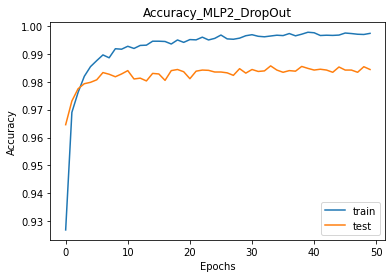

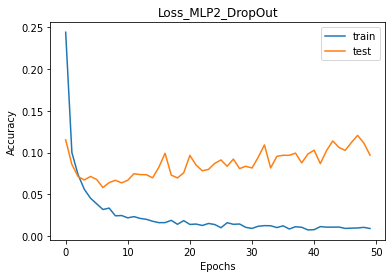

In [ ]:
# モデルの要約を表示
model_MLP2_DropOut.summary()

# モデルを評価
print('\n正解率 =', score_MLP2_DropOut[1], 'loss =', score_MLP2_DropOut[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP2_DropOut.history['accuracy'])
plt.plot(hist_MLP2_DropOut.history['val_accuracy'])
plt.title('Accuracy_MLP2_DropOut')
plt.legend(['train', 'test'], loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP2_DropOut.history['loss'])
plt.plot(hist_MLP2_DropOut.history['val_loss'])
plt.title('Loss_MLP2_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1) 
<a name="drop4"></a>
### <a href="#drop4">(3) 3層 MLP_dropout</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP3_DropOut = keras.models.Sequential()
model_MLP3_DropOut.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP3_DropOut.add(Dropout(0.2))
model_MLP3_DropOut.add(Dense(512, activation='relu'))
model_MLP3_DropOut.add(Dropout(0.2))
model_MLP3_DropOut.add(Dense(512, activation='relu'))
model_MLP3_DropOut.add(Dropout(0.2))
model_MLP3_DropOut.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP3_DropOut.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP3_DropOut = model_MLP3_DropOut.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP3_DropOut.save('numeral_mlp3_dropout_model.h5')

# モデルを評価
score_MLP3_DropOut = model_MLP3_DropOut.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_MLP3_DropOut[1], 'loss = ', score_MLP3_DropOut[0])

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2562 - accuracy: 0.9224 - val_loss: 0.1259 - val_accuracy: 0.9610
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1078 - accuracy: 0.9670 - val_loss: 0.0771 - val_accuracy: 0.9765
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0791 - accuracy: 0.9754 - val_loss: 0.0799 - val_accuracy: 0.9768
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0647 - accuracy: 0.9802 - val_loss: 0.0737 - val_accuracy: 0.9777
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0556 - accuracy: 0.9816 - val_loss: 0.0711 - val_accuracy: 0.9792
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0492 - accuracy: 0.9842 - val_loss: 0.0721 - val_accuracy: 0.9810
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.0725 - val_accuracy: 0.9801
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5

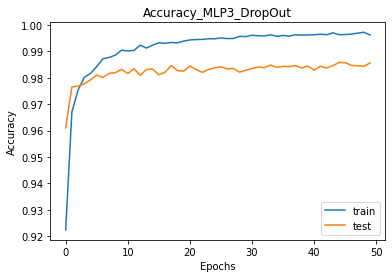

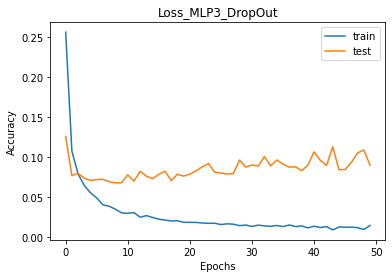

In [ ]:
# モデルの要約を表示
model_MLP3_DropOut.summary()

# モデルを評価
print('\n正解率 =', score_MLP3_DropOut[1], 'loss =', score_MLP3_DropOut[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP3_DropOut.history['accuracy'])
plt.plot(hist_MLP3_DropOut.history['val_accuracy'])
plt.title('Accuracy_MLP3_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP3_DropOut.history['loss'])
plt.plot(hist_MLP3_DropOut.history['val_loss'])
plt.title('Loss_MLP3_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1) 
<a name="drop5"></a>
### <a href="#drop5">(4) 5層 MLP_dropout</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP5_DropOut = keras.models.Sequential()
model_MLP5_DropOut.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP5_DropOut.add(Dropout(0.2))
model_MLP5_DropOut.add(Dense(512, activation='relu'))
model_MLP5_DropOut.add(Dropout(0.2))
model_MLP5_DropOut.add(Dense(512, activation='relu'))
model_MLP5_DropOut.add(Dropout(0.2))
model_MLP5_DropOut.add(Dense(512, activation='relu'))
model_MLP5_DropOut.add(Dropout(0.2))
model_MLP5_DropOut.add(Dense(512, activation='relu'))
model_MLP5_DropOut.add(Dropout(0.2))
model_MLP5_DropOut.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP5_DropOut.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP5_DropOut = model_MLP5_DropOut.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP5_DropOut.save('numeral_mlp5_dropout_model.h5')

# モデルを評価
score_MLP5_DropOut = model_MLP5_DropOut.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_MLP5_DropOut[1], 'loss = ', score_MLP5_DropOut[0])

Epoch 1/50
469/469 [==============================] - 5s 10ms/step - loss: 0.2962 - accuracy: 0.9085 - val_loss: 0.1237 - val_accuracy: 0.9640
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1328 - accuracy: 0.9611 - val_loss: 0.1068 - val_accuracy: 0.9718
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0975 - accuracy: 0.9715 - val_loss: 0.0881 - val_accuracy: 0.9756
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0823 - accuracy: 0.9769 - val_loss: 0.0876 - val_accuracy: 0.9748
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0693 - accuracy: 0.9800 - val_loss: 0.0770 - val_accuracy: 0.9795
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0622 - accuracy: 0.9816 - val_loss: 0.0755 - val_accuracy: 0.9792
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0547 - accuracy: 0.9840 - val_loss: 0.0744 - val_accuracy: 0.9790
Epoch

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

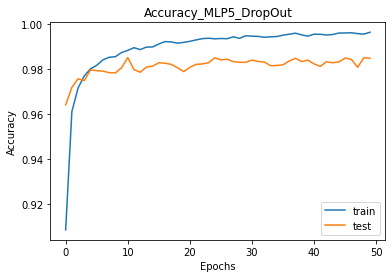

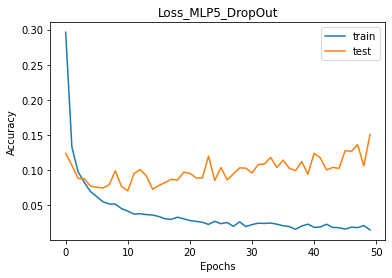

In [ ]:
# モデルの要約を表示
model_MLP5_DropOut.summary()

# モデルを評価
print('\n正解率 =', score_MLP5_DropOut[1], 'loss =', score_MLP5_DropOut[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP5_DropOut.history['accuracy'])
plt.plot(hist_MLP5_DropOut.history['val_accuracy'])
plt.title('Accuracy_MLP5_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP5_DropOut.history['loss'])
plt.plot(hist_MLP5_DropOut.history['val_loss'])
plt.title('Loss_MLP5_DropOut')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="drop6"></a>
### <a href="#drop6">(5) 層の深さの違いによるMLP-dropoutの結果比較</a>
層を深くしてもtest_Accuracyにほぼ変化がなく、test_Lossのベースラインが少し高くなる傾向が見られたよって、MLPにDropout=0.2を利用したMNISTのデータの学習では、単に層を深くしても汎化性能は向上しないことが示された。


MLP1-dropout 正解率 = 0.9836000204086304 loss = 0.09323955327272415

MLP2-dropout 正解率 = 0.9843999743461609 loss = 0.09687411785125732

MLP3-dropout 正解率 = 0.9855999946594238 loss = 0.09003818780183792

MLP5-dropout 正解率 = 0.9847000241279602 loss = 0.1508118212223053


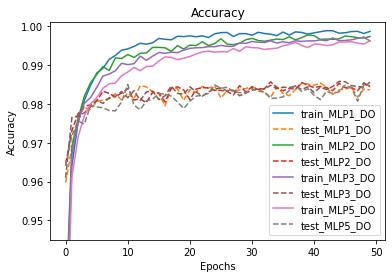

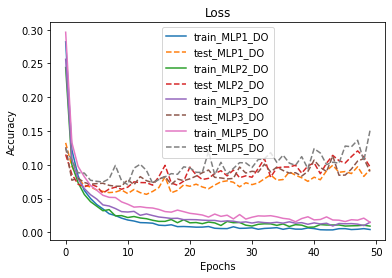

In [ ]:
# モデルを評価
print('\nMLP1-dropout', '正解率 =', score_MLP1_DropOut[1], 'loss =', score_MLP1_DropOut[0])
print('\nMLP2-dropout', '正解率 =', score_MLP2_DropOut[1], 'loss =', score_MLP2_DropOut[0])
print('\nMLP3-dropout', '正解率 =', score_MLP3_DropOut[1], 'loss =', score_MLP3_DropOut[0])
print('\nMLP5-dropout', '正解率 =', score_MLP5_DropOut[1], 'loss =', score_MLP5_DropOut[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1_DropOut.history['accuracy'])
plt.plot(hist_MLP1_DropOut.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP2_DropOut.history['accuracy'])
plt.plot(hist_MLP2_DropOut.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP3_DropOut.history['accuracy'])
plt.plot(hist_MLP3_DropOut.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP5_DropOut.history['accuracy'])
plt.plot(hist_MLP5_DropOut.history['val_accuracy'], linestyle="dashed")
plt.ylim(0.945, 1.001)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1_DO', 'test_MLP1_DO', 
            'train_MLP2_DO', 'test_MLP2_DO',
            'train_MLP3_DO', 'test_MLP3_DO', 
            'train_MLP5_DO', 'test_MLP5_DO',], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1_DropOut.history['loss'])
plt.plot(hist_MLP1_DropOut.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP2_DropOut.history['loss'])
plt.plot(hist_MLP2_DropOut.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP3_DropOut.history['loss'])
plt.plot(hist_MLP3_DropOut.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP5_DropOut.history['loss'])
plt.plot(hist_MLP5_DropOut.history['val_loss'], linestyle="dashed")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1_DO', 'test_MLP1_DO', 
            'train_MLP2_DO', 'test_MLP2_DO',
            'train_MLP3_DO', 'test_MLP3_DO', 
            'train_MLP5_DO', 'test_MLP5_DO',], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization1"></a>
## <a href="#BatchNormalization2">2. MLP_BatchNormalization</a> 
<a name="BatchNormalization2"></a>
### <a href="#BatchNormalization2">(1) 1層 MLP-BN</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP1_BN = keras.models.Sequential()
model_MLP1_BN.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP1_BN.add(BatchNormalization())
model_MLP1_BN.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP1_BN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP1_BN = model_MLP1_BN.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP1_BN.save('numeral_mlp1_BN_model.h5')

# モデルを評価
score_MLP1_BN = model_MLP1_BN.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP1_BN[1], 'loss =', score_MLP1_BN[0])

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1866 - accuracy: 0.9436 - val_loss: 0.1217 - val_accuracy: 0.9611
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0710 - accuracy: 0.9792 - val_loss: 0.0845 - val_accuracy: 0.9740
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0785 - val_accuracy: 0.9740
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 0.0795 - val_accuracy: 0.9753
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.0762 - val_accuracy: 0.9765
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0750 - val_accuracy: 0.9775
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 409,098
Trainable params: 408,074
Non-trainable params: 1,024
_________________________________________________________________

正解率 = 0.9817000031471252 loss = 0.09660501778125763


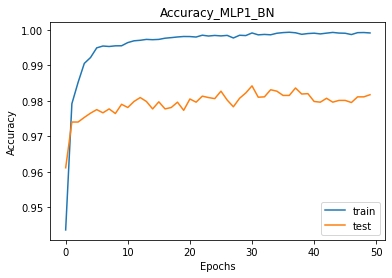

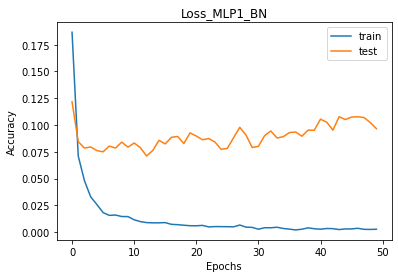

In [ ]:
# モデルの要約を表示
model_MLP1_BN.summary()

# モデルを評価
print('\n正解率 =', score_MLP1_BN[1], 'loss =', score_MLP1_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1_BN.history['accuracy'])
plt.plot(hist_MLP1_BN.history['val_accuracy'])
plt.title('Accuracy_MLP1_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1_BN.history['loss'])
plt.plot(hist_MLP1_BN.history['val_loss'])
plt.title('Loss_MLP1_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization3"></a>
### <a href="#BatchNormalization3">(2) 2層 MLP-BN</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP2_BN = keras.models.Sequential()
model_MLP2_BN.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP2_BN.add(BatchNormalization())
model_MLP2_BN.add(Dense(512, activation='relu'))
model_MLP2_BN.add(BatchNormalization())
model_MLP2_BN.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP2_BN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP2_BN = model_MLP2_BN.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP2_BN.save('numeral_mlp2_BN_model.h5')

# モデルを評価
score_MLP2_BN = model_MLP2_BN.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP2_BN[1], 'loss =', score_MLP2_BN[0])

Epoch 1/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1719 - accuracy: 0.9479 - val_loss: 0.1129 - val_accuracy: 0.9651
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0700 - accuracy: 0.9782 - val_loss: 0.0872 - val_accuracy: 0.9743
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0468 - accuracy: 0.9849 - val_loss: 0.0887 - val_accuracy: 0.9724
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.0953 - val_accuracy: 0.9722
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0747 - val_accuracy: 0.9782
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0760 - val_accuracy: 0.9796
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0226 - accuracy: 0.9922 - val_loss: 0.0760 - val_accuracy: 0.9789
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 673,802
Trainable params: 671,754
Non-trainable params: 2,048
_________________________________________________________________

正解率 = 0.9830999970436096 loss = 0.09466710686683655


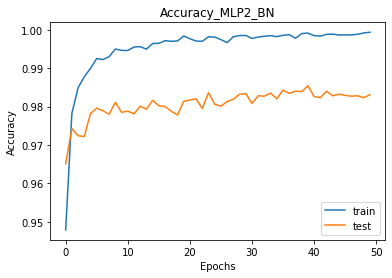

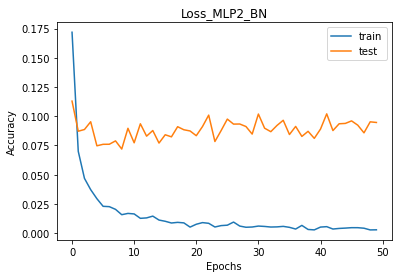

In [ ]:
# モデルの要約を表示
model_MLP2_BN.summary()

# モデルを評価
print('\n正解率 =', score_MLP2_BN[1], 'loss =', score_MLP2_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP2_BN.history['accuracy'])
plt.plot(hist_MLP2_BN.history['val_accuracy'])
plt.title('Accuracy_MLP2_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP2_BN.history['loss'])
plt.plot(hist_MLP2_BN.history['val_loss'])
plt.title('Loss_MLP2_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization4"></a>
### <a href="#BatchNormalization4">(3) 3層 MLP-BN</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP3_BN = keras.models.Sequential()
model_MLP3_BN.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP3_BN.add(BatchNormalization())
model_MLP3_BN.add(Dense(512, activation='relu'))
model_MLP3_BN.add(BatchNormalization())
model_MLP3_BN.add(Dense(512, activation='relu'))
model_MLP3_BN.add(BatchNormalization())
model_MLP3_BN.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP3_BN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP3_BN = model_MLP3_BN.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP3_BN.save('numeral_mlp3_BN_model.h5')

# モデルを評価
score_MLP3_BN = model_MLP3_BN.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP3_BN[1], 'loss =', score_MLP3_BN[0])

Epoch 1/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1758 - accuracy: 0.9462 - val_loss: 0.1025 - val_accuracy: 0.9677
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0720 - accuracy: 0.9765 - val_loss: 0.0823 - val_accuracy: 0.9740
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0524 - accuracy: 0.9833 - val_loss: 0.0998 - val_accuracy: 0.9707
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.0892 - val_accuracy: 0.9755
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.0948 - val_accuracy: 0.9725
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0328 - accuracy: 0.9892 - val_loss: 0.0692 - val_accuracy: 0.9803
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0255 - accuracy: 0.9917 - val_loss: 0.0850 - val_accuracy: 0.9769
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5

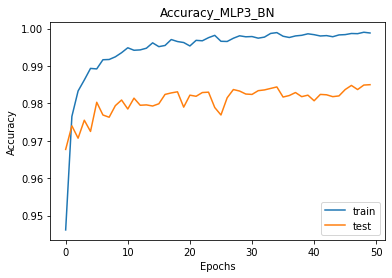

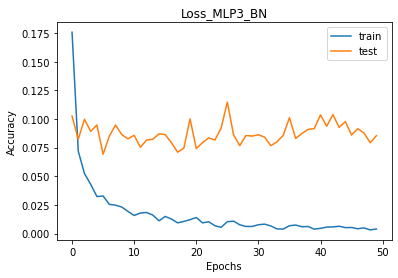

In [ ]:
# モデルの要約を表示
model_MLP3_BN.summary()

# モデルを評価
print('\n正解率 =', score_MLP3_BN[1], 'loss =', score_MLP3_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP3_BN.history['accuracy'])
plt.plot(hist_MLP3_BN.history['val_accuracy'])
plt.title('Accuracy_MLP3_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP3_BN.history['loss'])
plt.plot(hist_MLP3_BN.history['val_loss'])
plt.title('Loss_MLP3_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization5"></a>
### <a href="#BatchNormalization5">(4) 5層 MLP-BN</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データを28*28=784の一次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# 識別子をリセット
K.clear_session()

# モデルを構築を定義
Dense = keras.layers.Dense
model_MLP5_BN = keras.models.Sequential()
model_MLP5_BN.add(Dense(512, activation='relu', input_shape=(in_size,)))
model_MLP5_BN.add(BatchNormalization())
model_MLP5_BN.add(Dense(512, activation='relu'))
model_MLP5_BN.add(BatchNormalization())
model_MLP5_BN.add(Dense(512, activation='relu'))
model_MLP5_BN.add(BatchNormalization())
model_MLP5_BN.add(Dense(512, activation='relu'))
model_MLP5_BN.add(BatchNormalization())
model_MLP5_BN.add(Dense(512, activation='relu'))
model_MLP5_BN.add(BatchNormalization())
model_MLP5_BN.add(Dense(out_size, activation='softmax'))

# モデルを構築
model_MLP5_BN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_MLP5_BN = model_MLP5_BN.fit(X_train, y_train,
                              batch_size=128, epochs=50, verbose=1,
                              validation_data=(X_test, y_test))

# モデルを保存
model_MLP5_BN.save('numeral_mlp5_BN_model.h5')

# モデルを評価
score_MLP5_BN = model_MLP5_BN.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_MLP5_BN[1], 'loss =', score_MLP5_BN[0])

Epoch 1/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1979 - accuracy: 0.9402 - val_loss: 0.1124 - val_accuracy: 0.9671
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0894 - accuracy: 0.9725 - val_loss: 0.1078 - val_accuracy: 0.9676
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.1086 - val_accuracy: 0.9679
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0875 - val_accuracy: 0.9747
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0491 - accuracy: 0.9843 - val_loss: 0.0783 - val_accuracy: 0.9768
Epoch 6/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0426 - accuracy: 0.9862 - val_loss: 0.1128 - val_accuracy: 0.9712
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.0790 - val_accuracy: 0.9793
E

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

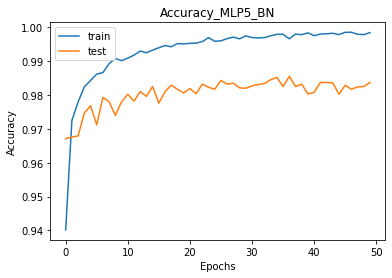

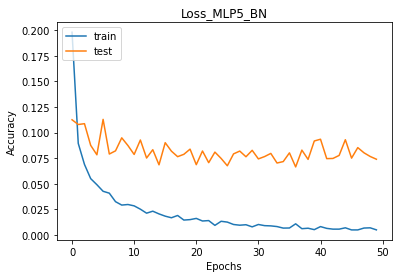

In [ ]:
# モデルの要約を表示
model_MLP5_BN.summary()

# モデルを評価
print('\n正解率 =', score_MLP5_BN[1], 'loss =', score_MLP5_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP5_BN.history['accuracy'])
plt.plot(hist_MLP5_BN.history['val_accuracy'])
plt.title('Accuracy_MLP5_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP5_BN.history['loss'])
plt.plot(hist_MLP5_BN.history['val_loss'])
plt.title('Loss_MLP5_BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization6"></a>
### <a href="#BatchNormalization6">(5) 層の深さの違いによるMLP-BNの結果比較</a>
層を深くするとtest_Accuracyが変化若干良くなり、test_Lossのベースラインも若干低くなる傾向が見られた。よって、MLPにBatchNormalizationを利用したMNISTのデータの学習では、層を深くすることでtest_Accuracyの向上とtest_Lossの低下するのではないかと考えられる。今回より層を深くしたときに顕著に影響が現れると思われる。


MLP1-BN 正解率 = 0.9817000031471252 loss = 0.09660501778125763

MLP2-BN 正解率 = 0.9830999970436096 loss = 0.09466710686683655

MLP3-BN 正解率 = 0.9850000143051147 loss = 0.08545622229576111

MLP5-BN 正解率 = 0.9836999773979187 loss = 0.07392261922359467


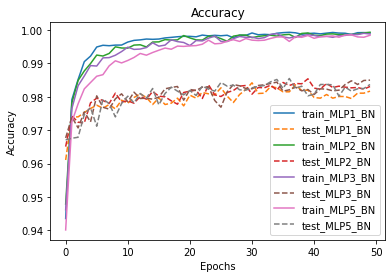

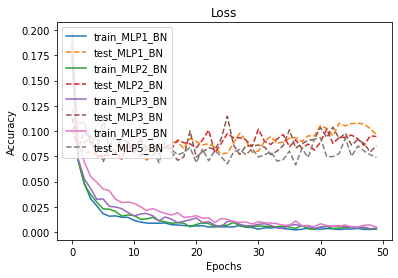

In [ ]:
# モデルを評価
print('\nMLP1-BN', '正解率 =', score_MLP1_BN[1], 'loss =', score_MLP1_BN[0])
print('\nMLP2-BN', '正解率 =', score_MLP2_BN[1], 'loss =', score_MLP2_BN[0])
print('\nMLP3-BN', '正解率 =', score_MLP3_BN[1], 'loss =', score_MLP3_BN[0])
print('\nMLP5-BN', '正解率 =', score_MLP5_BN[1], 'loss =', score_MLP5_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP1_BN.history['accuracy'])
plt.plot(hist_MLP1_BN.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP2_BN.history['accuracy'])
plt.plot(hist_MLP2_BN.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP3_BN.history['accuracy'])
plt.plot(hist_MLP3_BN.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP5_BN.history['accuracy'])
plt.plot(hist_MLP5_BN.history['val_accuracy'], linestyle="dashed")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1_BN', 'test_MLP1_BN', 
            'train_MLP2_BN', 'test_MLP2_BN',
            'train_MLP3_BN', 'test_MLP3_BN', 
            'train_MLP5_BN', 'test_MLP5_BN',], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP1_BN.history['loss'])
plt.plot(hist_MLP1_BN.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP2_BN.history['loss'])
plt.plot(hist_MLP2_BN.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP3_BN.history['loss'])
plt.plot(hist_MLP3_BN.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP5_BN.history['loss'])
plt.plot(hist_MLP5_BN.history['val_loss'], linestyle="dashed")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP1_BN', 'test_MLP1_BN', 
            'train_MLP2_BN', 'test_MLP2_BN',
            'train_MLP3_BN', 'test_MLP3_BN', 
            'train_MLP5_BN', 'test_MLP5_BN',], loc='upper left')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="BatchNormalization7"></a>
### <a href="#BatchNormalization7">(6) 各MLPの結果比較</a>
各３層のMLPの結果を示した。DropoutとBatch Normalizationを行うことでtest_accuracyの若干の向上とtest_lossの低下を確認することができる。


MLP3 正解率 = 0.9836000204086304 loss = 0.13720962405204773

MLP3-dropout 正解率 = 0.9855999946594238 loss = 0.09003818780183792

MLP3-BN 正解率 = 0.9850000143051147 loss = 0.08545622229576111


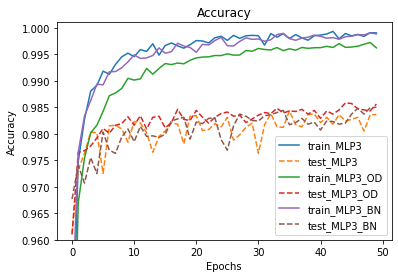

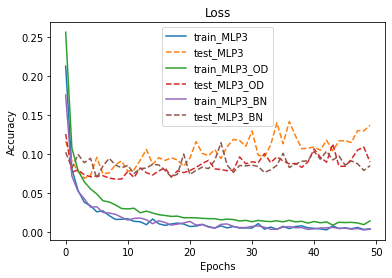

In [ ]:
# モデルを評価
print('\nMLP3', '正解率 =', score_MLP3[1], 'loss =', score_MLP3[0])
print('\nMLP3-dropout', '正解率 =', score_MLP3_DropOut[1], 'loss =', score_MLP3_DropOut[0])
print('\nMLP3-BN', '正解率 =', score_MLP3_BN[1], 'loss =', score_MLP3_BN[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_MLP3.history['accuracy'])
plt.plot(hist_MLP3.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP3_DropOut.history['accuracy'])
plt.plot(hist_MLP3_DropOut.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_MLP3_BN.history['accuracy'])
plt.plot(hist_MLP3_BN.history['val_accuracy'], linestyle="dashed")
plt.ylim(0.96, 1.001)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP3', 'test_MLP3', 
            'train_MLP3_OD', 'test_MLP3_OD',
            'train_MLP3_BN', 'test_MLP3_BN'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_MLP3.history['loss'])
plt.plot(hist_MLP3.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP3_DropOut.history['loss'])
plt.plot(hist_MLP3_DropOut.history['val_loss'], linestyle="dashed")
plt.plot(hist_MLP3_BN.history['loss'])
plt.plot(hist_MLP3_BN.history['val_loss'], linestyle="dashed")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_MLP3', 'test_MLP3', 
            'train_MLP3_OD', 'test_MLP3_OD',
            'train_MLP3_BN', 'test_MLP3_BN'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="cnn1"></a>
## <a href="#cnn1">4. CNN</a> 
<a name="cnn2"></a>
### <a href="#cnn2">(1) CNN 32</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_CNN32 = Sequential()
model_CNN32.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_CNN32.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_CNN32.add(MaxPooling2D(pool_size=(2,2)))
model_CNN32.add(Dropout(0.25))
model_CNN32.add(Flatten())
model_CNN32.add(Dense(128, activation='softmax'))
model_CNN32.add(Dropout(0.5))
model_CNN32.add(Dense(out_size, activation='softmax'))

# モデルをコンパイル
model_CNN32.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_CNN32 = model_CNN32.fit(X_train, y_train,
                     batch_size=32, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_CNN32.save('numeral_cnn32_model.h5')

# モデルを評価
score_CNN32 = model_CNN32.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_CNN32[1], 'loss = ', score_CNN32[0])

Epoch 1/50
1875/1875 [==============================] - 35s 19ms/step - loss: 1.6889 - accuracy: 0.3865 - val_loss: 1.1178 - val_accuracy: 0.6855
Epoch 2/50
1875/1875 [==============================] - 35s 19ms/step - loss: 1.4389 - accuracy: 0.4174 - val_loss: 0.8407 - val_accuracy: 0.8370
Epoch 3/50
1875/1875 [==============================] - 35s 19ms/step - loss: 1.1799 - accuracy: 0.5843 - val_loss: 0.4417 - val_accuracy: 0.9846
Epoch 4/50
1875/1875 [==============================] - 36s 19ms/step - loss: 0.9835 - accuracy: 0.6599 - val_loss: 0.3090 - val_accuracy: 0.9839
Epoch 5/50
1875/1875 [==============================] - 38s 20ms/step - loss: 0.8151 - accuracy: 0.7249 - val_loss: 0.1773 - val_accuracy: 0.9871
Epoch 6/50
1875/1875 [==============================] - 38s 20ms/step - loss: 0.7291 - accuracy: 0.7536 - val_loss: 0.1217 - val_accuracy: 0.9887
Epoch 7/50
1875/1875 [==============================] - 36s 19ms/step - loss: 0.6575 - accuracy: 0.7805 - val_loss: 0.1035 -

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

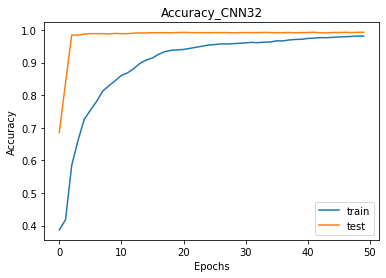

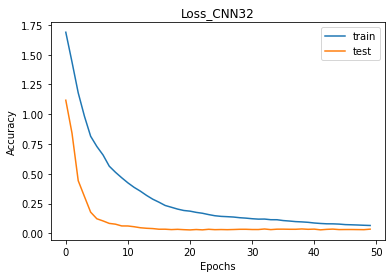

In [ ]:
# モデルの要約を表示
model_CNN32.summary()

# モデルを評価
print('\n正解率 =', score_CNN32[1], 'loss =', score_CNN32[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_CNN32.history['accuracy'])
plt.plot(hist_CNN32.history['val_accuracy'])
plt.title('Accuracy_CNN32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_CNN32.history['loss'])
plt.plot(hist_CNN32.history['val_loss'])
plt.title('Loss_CNN32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="cnn3"></a>
### <a href="#cnn3">(2) CNN 64</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_CNN64 = Sequential()
model_CNN64.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_CNN64.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_CNN64.add(MaxPooling2D(pool_size=(2,2)))
model_CNN64.add(Dropout(0.25))
model_CNN64.add(Flatten())
model_CNN64.add(Dense(128, activation='softmax'))
model_CNN64.add(Dropout(0.5))
model_CNN64.add(Dense(out_size, activation='softmax'))

# モデルをコンパイル
model_CNN64.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_CNN64 = model_CNN64.fit(X_train, y_train,
                     batch_size=64, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_CNN64.save('numeral_cnn64_model.h5')

# モデルを評価
score_CNN64 = model_CNN64.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_CNN64[1], 'loss = ', score_CNN64[0])

Epoch 1/50
938/938 [==============================] - 34s 36ms/step - loss: 1.8162 - accuracy: 0.3455 - val_loss: 1.3779 - val_accuracy: 0.6131
Epoch 2/50
938/938 [==============================] - 35s 37ms/step - loss: 1.5560 - accuracy: 0.3608 - val_loss: 1.1213 - val_accuracy: 0.6168
Epoch 3/50
938/938 [==============================] - 34s 37ms/step - loss: 1.4369 - accuracy: 0.4281 - val_loss: 0.8351 - val_accuracy: 0.8789
Epoch 4/50
938/938 [==============================] - 34s 36ms/step - loss: 1.2844 - accuracy: 0.5064 - val_loss: 0.6468 - val_accuracy: 0.9140
Epoch 5/50
938/938 [==============================] - 33s 36ms/step - loss: 1.0766 - accuracy: 0.6165 - val_loss: 0.4156 - val_accuracy: 0.9847
Epoch 6/50
938/938 [==============================] - 33s 35ms/step - loss: 0.9591 - accuracy: 0.6449 - val_loss: 0.2963 - val_accuracy: 0.9862
Epoch 7/50
938/938 [==============================] - 34s 37ms/step - loss: 0.8977 - accuracy: 0.6686 - val_loss: 0.2484 - val_accuracy:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

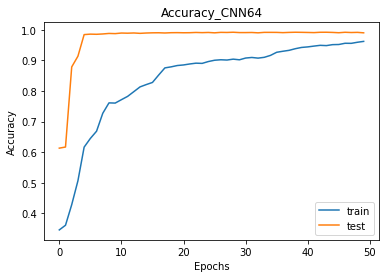

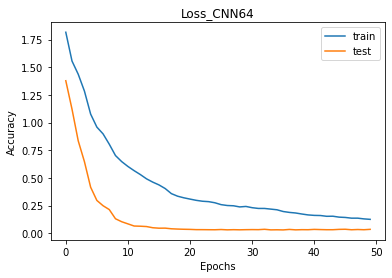

In [ ]:
# モデルの要約を表示
model_CNN64.summary()

# モデルを評価
print('\n正解率 =', score_CNN64[1], 'loss =', score_CNN64[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_CNN64.history['accuracy'])
plt.plot(hist_CNN64.history['val_accuracy'])
plt.title('Accuracy_CNN64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_CNN64.history['loss'])
plt.plot(hist_CNN64.history['val_loss'])
plt.title('Loss_CNN64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="cnn4"></a>
### <a href="#cnn4">(3) CNN 128</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_CNN128 = Sequential()
model_CNN128.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_CNN128.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_CNN128.add(MaxPooling2D(pool_size=(2,2)))
model_CNN128.add(Dropout(0.25))
model_CNN128.add(Flatten())
model_CNN128.add(Dense(128, activation='softmax'))
model_CNN128.add(Dropout(0.5))
model_CNN128.add(Dense(out_size, activation='softmax'))

# モデルをコンパイル
model_CNN128.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_CNN128 = model_CNN128.fit(X_train, y_train,
                     batch_size=128, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_CNN128.save('numeral_cnn128_model.h5')

# モデルを評価
score_CNN128 = model_CNN128.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_CNN128[1], 'loss = ', score_CNN128[0])

Epoch 1/50
469/469 [==============================] - 32s 69ms/step - loss: 1.8990 - accuracy: 0.3919 - val_loss: 1.5639 - val_accuracy: 0.6986
Epoch 2/50
469/469 [==============================] - 31s 67ms/step - loss: 1.5793 - accuracy: 0.4091 - val_loss: 1.2537 - val_accuracy: 0.7011
Epoch 3/50
469/469 [==============================] - 31s 67ms/step - loss: 1.4931 - accuracy: 0.4074 - val_loss: 1.0948 - val_accuracy: 0.7017
Epoch 4/50
469/469 [==============================] - 31s 67ms/step - loss: 1.4585 - accuracy: 0.4073 - val_loss: 0.9921 - val_accuracy: 0.7072
Epoch 5/50
469/469 [==============================] - 31s 67ms/step - loss: 1.3919 - accuracy: 0.4588 - val_loss: 0.7994 - val_accuracy: 0.8823
Epoch 6/50
469/469 [==============================] - 31s 67ms/step - loss: 1.2774 - accuracy: 0.5201 - val_loss: 0.6795 - val_accuracy: 0.9837
Epoch 7/50
469/469 [==============================] - 31s 67ms/step - loss: 1.1542 - accuracy: 0.5718 - val_loss: 0.5215 - val_accuracy:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

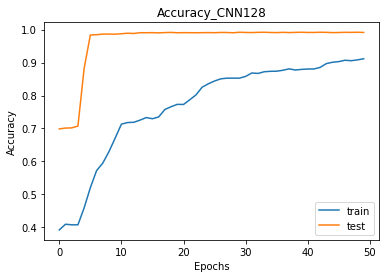

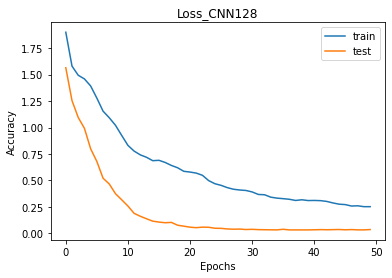

In [ ]:
# モデルの要約を表示
model_CNN128.summary()

# モデルを評価
print('\n正解率 =', score_CNN128[1], 'loss =', score_CNN128[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_CNN128.history['accuracy'])
plt.plot(hist_CNN128.history['val_accuracy'])
plt.title('Accuracy_CNN128')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_CNN128.history['loss'])
plt.plot(hist_CNN128.history['val_loss'])
plt.title('Loss_CNN128')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="cnn5"></a>
### <a href="#cnn5">(4) CNN 256</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_CNN256 = Sequential()
model_CNN256.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_CNN256.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_CNN256.add(MaxPooling2D(pool_size=(2,2)))
model_CNN256.add(Dropout(0.25))
model_CNN256.add(Flatten())
model_CNN256.add(Dense(128, activation='softmax'))
model_CNN256.add(Dropout(0.5))
model_CNN256.add(Dense(out_size, activation='softmax'))

# モデルをコンパイル
model_CNN256.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_CNN256 = model_CNN256.fit(X_train, y_train,
                     batch_size=256, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_CNN256.save('numeral_cnn256_model.h5')

# モデルを評価
score_CNN256 = model_CNN256.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_CNN256[1], 'loss = ', score_CNN256[0])

Epoch 1/50
235/235 [==============================] - 30s 129ms/step - loss: 1.9967 - accuracy: 0.4494 - val_loss: 1.7669 - val_accuracy: 0.8516
Epoch 2/50
235/235 [==============================] - 30s 127ms/step - loss: 1.6731 - accuracy: 0.4941 - val_loss: 1.4287 - val_accuracy: 0.8792
Epoch 3/50
235/235 [==============================] - 30s 126ms/step - loss: 1.4861 - accuracy: 0.4985 - val_loss: 1.1964 - val_accuracy: 0.8880
Epoch 4/50
235/235 [==============================] - 30s 126ms/step - loss: 1.3908 - accuracy: 0.4982 - val_loss: 1.0396 - val_accuracy: 0.8926
Epoch 5/50
235/235 [==============================] - 30s 126ms/step - loss: 1.3388 - accuracy: 0.4998 - val_loss: 0.9307 - val_accuracy: 0.8927
Epoch 6/50
235/235 [==============================] - 30s 127ms/step - loss: 1.3120 - accuracy: 0.4994 - val_loss: 0.8446 - val_accuracy: 0.8934
Epoch 7/50
235/235 [==============================] - 30s 126ms/step - loss: 1.2964 - accuracy: 0.5002 - val_loss: 0.7756 - val_ac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

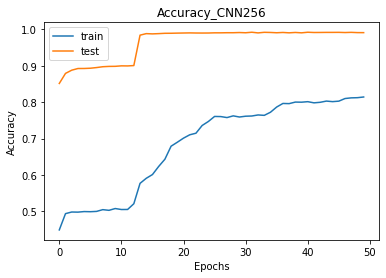

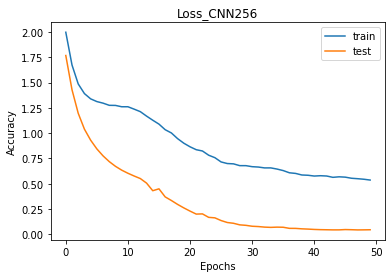

In [ ]:
# モデルの要約を表示
model_CNN256.summary()

# モデルを評価
print('\n正解率 =', score_CNN256[1], 'loss =', score_CNN256[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_CNN256.history['accuracy'])
plt.plot(hist_CNN256.history['val_accuracy'])
plt.title('Accuracy_CNN256')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_CNN256.history['loss'])
plt.plot(hist_CNN256.history['val_loss'])
plt.title('Loss_CNN256')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="cnn6"></a>
### <a href="#cnn6">(5) Batch sizeの違いによるCNNの結果比較</a>
MNISTの手書き数字データを利用したCNNによる学習では、50 epochsに統一、batch sizeを256から32に増やし学習回数を稼いだ方が良い傾向が見られ、test_Accuracyの若干向上とtest_Lossの若干の減少が確認できた。


CNN32 正解率 = 0.992900013923645 loss = 0.03454427793622017

CNN64 正解率 = 0.9904999732971191 loss = 0.034952983260154724

CNN128 正解率 = 0.9915000200271606 loss = 0.03684792295098305

CNN256 正解率 = 0.991100013256073 loss = 0.04601946100592613


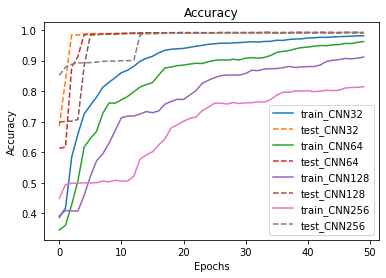

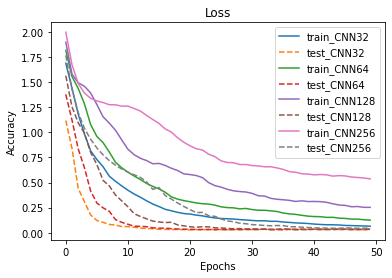

In [ ]:
# モデルを評価
print('\nCNN32', '正解率 =', score_CNN32[1], 'loss =', score_CNN32[0])
print('\nCNN64', '正解率 =', score_CNN64[1], 'loss =', score_CNN64[0])
print('\nCNN128', '正解率 =', score_CNN128[1], 'loss =', score_CNN128[0])
print('\nCNN256', '正解率 =', score_CNN256[1], 'loss =', score_CNN256[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_CNN32.history['accuracy'])
plt.plot(hist_CNN32.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_CNN64.history['accuracy'])
plt.plot(hist_CNN64.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_CNN128.history['accuracy'])
plt.plot(hist_CNN128.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_CNN256.history['accuracy'])
plt.plot(hist_CNN256.history['val_accuracy'], linestyle="dashed")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_CNN32', 'test_CNN32', 
            'train_CNN64', 'test_CNN64',
            'train_CNN128', 'test_CNN128', 
            'train_CNN256', 'test_CNN256',], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_CNN32.history['loss'])
plt.plot(hist_CNN32.history['val_loss'], linestyle="dashed")
plt.plot(hist_CNN64.history['loss'])
plt.plot(hist_CNN64.history['val_loss'], linestyle="dashed")
plt.plot(hist_CNN128.history['loss'])
plt.plot(hist_CNN128.history['val_loss'], linestyle="dashed")
plt.plot(hist_CNN256.history['loss'])
plt.plot(hist_CNN256.history['val_loss'], linestyle="dashed")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_CNN32', 'test_CNN32', 
            'train_CNN64', 'test_CNN64',
            'train_CNN128', 'test_CNN128', 
            'train_CNN256', 'test_CNN256',], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="vgg1"></a>
## <a href="#vgg1">5. VGG-like</a> 
<a name="vgg2"></a>
### <a href="#vgg2">(1) VGG-like 32</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# CNNモデル構造を定義
model_VGG_like32 = Sequential()
model_VGG_like32.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape))
model_VGG_like32.add(Activation('relu'))
model_VGG_like32.add(Conv2D(32, kernel_size=(3,3)))
model_VGG_like32.add(Activation('relu'))
model_VGG_like32.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like32.add(Dropout(0.25))

model_VGG_like32.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_VGG_like32.add(Activation('relu'))
model_VGG_like32.add(Conv2D(64, kernel_size=(3,3)))
model_VGG_like32.add(Activation('relu'))
model_VGG_like32.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like32.add(Dropout(0.25))

model_VGG_like32.add(Flatten())
model_VGG_like32.add(Dense(512))
model_VGG_like32.add(Activation('relu'))
model_VGG_like32.add(Dropout(0.5))
model_VGG_like32.add(Dense(out_size))
model_VGG_like32.add(Activation('softmax'))

          
# モデルをコンパイル
model_VGG_like32.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_VGG_like32 = model_VGG_like32.fit(X_train, y_train,
                     batch_size=32, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_VGG_like32.save('numeral_VGG_like32_model.h5')

# モデルを評価
score_VGG_like32 = model_VGG_like32.evaluate(X_test, y_test, verbose=1)
print('正解率 = ', score_VGG_like32[1], 'loss = ', score_VGG_like32[0])

Epoch 1/50
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1541 - accuracy: 0.9507 - val_loss: 0.0413 - val_accuracy: 0.9873
Epoch 2/50
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0579 - accuracy: 0.9828 - val_loss: 0.0271 - val_accuracy: 0.9909
Epoch 3/50
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0442 - accuracy: 0.9859 - val_loss: 0.0264 - val_accuracy: 0.9916
Epoch 4/50
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0389 - accuracy: 0.9883 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 5/50
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0225 - val_accuracy: 0.9927
Epoch 6/50
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.0216 - val_accuracy: 0.9931
Epoch 7/50
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0199 -

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)       

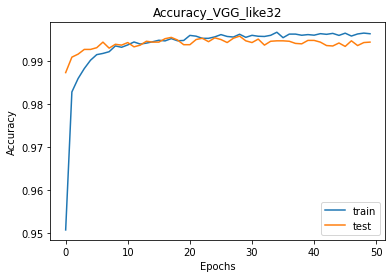

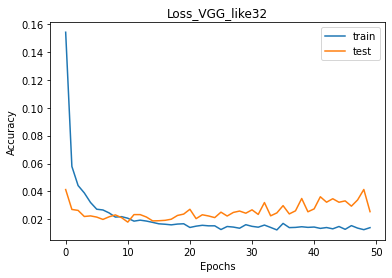

In [ ]:
# モデルの要約を表示
model_VGG_like32.summary()

# モデルを評価
print('\n正解率 =', score_VGG_like32[1], 'loss =', score_VGG_like32[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_VGG_like32.history['accuracy'])
plt.plot(hist_VGG_like32.history['val_accuracy'])
plt.title('Accuracy_VGG_like32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_VGG_like32.history['loss'])
plt.plot(hist_VGG_like32.history['val_loss'])
plt.title('Loss_VGG_like32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="vgg3"></a>
### <a href="#vgg3">(2) VGG-like 64</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_VGG_like64 = Sequential()
model_VGG_like64.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape))
model_VGG_like64.add(Activation('relu'))
model_VGG_like64.add(Conv2D(32, kernel_size=(3,3)))
model_VGG_like64.add(Activation('relu'))
model_VGG_like64.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like64.add(Dropout(0.25))

model_VGG_like64.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_VGG_like64.add(Activation('relu'))
model_VGG_like64.add(Conv2D(64, kernel_size=(3,3)))
model_VGG_like64.add(Activation('relu'))
model_VGG_like64.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like64.add(Dropout(0.25))

model_VGG_like64.add(Flatten())
model_VGG_like64.add(Dense(512))
model_VGG_like64.add(Activation('relu'))
model_VGG_like64.add(Dropout(0.5))
model_VGG_like64.add(Dense(out_size))
model_VGG_like64.add(Activation('softmax'))

          
# モデルをコンパイル
model_VGG_like64.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_VGG_like64 = model_VGG_like64.fit(X_train, y_train,
                     batch_size=64, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_VGG_like64.save('numeral_VGG_like64_model.h5')

# モデルを評価
score_VGG_like64 = model_VGG_like64.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_VGG_like64[1], 'loss =', score_VGG_like64[0])

Epoch 1/50
938/938 [==============================] - 40s 43ms/step - loss: 0.1710 - accuracy: 0.9465 - val_loss: 0.0386 - val_accuracy: 0.9873
Epoch 2/50
938/938 [==============================] - 40s 42ms/step - loss: 0.0577 - accuracy: 0.9819 - val_loss: 0.0325 - val_accuracy: 0.9891
Epoch 3/50
938/938 [==============================] - 40s 42ms/step - loss: 0.0461 - accuracy: 0.9863 - val_loss: 0.0209 - val_accuracy: 0.9932
Epoch 4/50
938/938 [==============================] - 40s 43ms/step - loss: 0.0354 - accuracy: 0.9893 - val_loss: 0.0171 - val_accuracy: 0.9935
Epoch 5/50
938/938 [==============================] - 40s 42ms/step - loss: 0.0324 - accuracy: 0.9902 - val_loss: 0.0178 - val_accuracy: 0.9945
Epoch 6/50
938/938 [==============================] - 40s 42ms/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.0216 - val_accuracy: 0.9927
Epoch 7/50
938/938 [==============================] - 40s 43ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0176 - val_accuracy:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

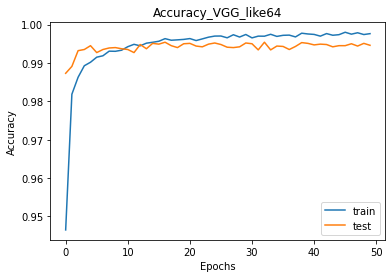

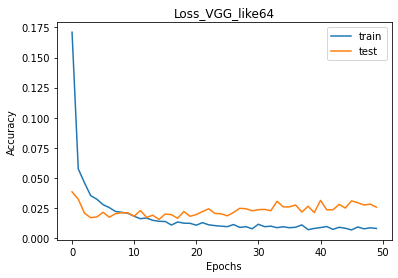

In [ ]:
# モデルの要約を表示
model_VGG_like64.summary()

# モデルを評価
print('\n正解率 =', score_VGG_like64[1], 'loss =', score_VGG_like64[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_VGG_like64.history['accuracy'])
plt.plot(hist_VGG_like64.history['val_accuracy'])
plt.title('Accuracy_VGG_like64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_VGG_like64.history['loss'])
plt.plot(hist_VGG_like64.history['val_loss'])
plt.title('Loss_VGG_like64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="vgg4"></a>
### <a href="#vgg4">(3) VGG-like 128</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_VGG_like128 = Sequential()
model_VGG_like128.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape))
model_VGG_like128.add(Activation('relu'))
model_VGG_like128.add(Conv2D(32, kernel_size=(3,3)))
model_VGG_like128.add(Activation('relu'))
model_VGG_like128.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like128.add(Dropout(0.25))

model_VGG_like128.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_VGG_like128.add(Activation('relu'))
model_VGG_like128.add(Conv2D(64, kernel_size=(3,3)))
model_VGG_like128.add(Activation('relu'))
model_VGG_like128.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like128.add(Dropout(0.25))

model_VGG_like128.add(Flatten())
model_VGG_like128.add(Dense(512))
model_VGG_like128.add(Activation('relu'))
model_VGG_like128.add(Dropout(0.5))
model_VGG_like128.add(Dense(out_size))
model_VGG_like128.add(Activation('softmax'))

          
# モデルをコンパイル
model_VGG_like128.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_VGG_like128 = model_VGG_like128.fit(X_train, y_train,
                     batch_size=128, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_VGG_like128.save('numeral_VGG_like128_model.h5')

# モデルを評価
score_VGG_like128 = model_VGG_like128.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_VGG_like128[1], 'loss =', score_VGG_like128[0])

Epoch 1/50
469/469 [==============================] - 43s 91ms/step - loss: 0.2137 - accuracy: 0.9327 - val_loss: 0.0419 - val_accuracy: 0.9864
Epoch 2/50
469/469 [==============================] - 43s 92ms/step - loss: 0.0614 - accuracy: 0.9811 - val_loss: 0.0286 - val_accuracy: 0.9903
Epoch 3/50
469/469 [==============================] - 40s 86ms/step - loss: 0.0459 - accuracy: 0.9860 - val_loss: 0.0295 - val_accuracy: 0.9911
Epoch 4/50
469/469 [==============================] - 40s 84ms/step - loss: 0.0357 - accuracy: 0.9888 - val_loss: 0.0220 - val_accuracy: 0.9932
Epoch 5/50
469/469 [==============================] - 39s 84ms/step - loss: 0.0313 - accuracy: 0.9899 - val_loss: 0.0257 - val_accuracy: 0.9913
Epoch 6/50
469/469 [==============================] - 39s 84ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0226 - val_accuracy: 0.9934
Epoch 7/50
469/469 [==============================] - 39s 84ms/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 0.0204 - val_accuracy:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

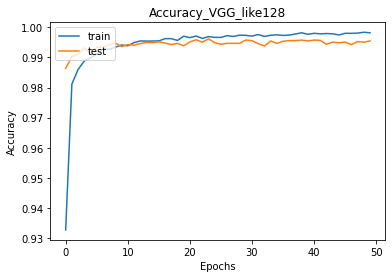

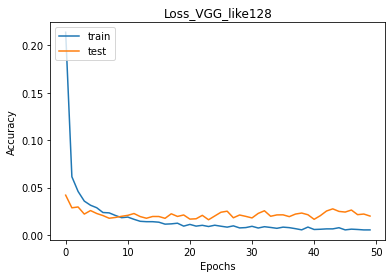

In [ ]:
# モデルの要約を表示
model_VGG_like128.summary()

# モデルを評価
print('\n正解率 =', score_VGG_like128[1], 'loss =', score_VGG_like128[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_VGG_like128.history['accuracy'])
plt.plot(hist_VGG_like128.history['val_accuracy'])
plt.title('Accuracy_VGG_like128')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移プロット
plt.plot(hist_VGG_like128.history['loss'])
plt.plot(hist_VGG_like128.history['val_loss'])
plt.title('Loss_VGG_like128')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="vgg5"></a>
### <a href="#vgg5">(4) VGG-like 256</a> 

In [ ]:
# 必要なモジュールをインポート
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


# 入力と出力を指定
im_rows = 28  # 画像の縦ピクセルサイズ
im_cols = 28  # 画像の横ピクセルサイズ
im_color = 1  # 画像の色空間をグレースケール
input_shape = (im_rows, im_cols, im_color)
out_size = 10

# MNISTのデータを読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 読み込んだデータを三次元配列に変換、0-1に正規化
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float32') / 255

# ラベルデータをone-hotベクトルに変換
y_train = keras.utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.to_categorical(y_test.astype('int32'), 10)

# 識別子をリセット
K.clear_session()

# CNNモデル構造を定義
model_VGG_like256 = Sequential()
model_VGG_like256.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape))
model_VGG_like256.add(Activation('relu'))
model_VGG_like256.add(Conv2D(32, kernel_size=(3,3)))
model_VGG_like256.add(Activation('relu'))
model_VGG_like256.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like256.add(Dropout(0.25))

model_VGG_like256.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_VGG_like256.add(Activation('relu'))
model_VGG_like256.add(Conv2D(64, kernel_size=(3,3)))
model_VGG_like256.add(Activation('relu'))
model_VGG_like256.add(MaxPooling2D(pool_size=(2,2)))
model_VGG_like256.add(Dropout(0.25))

model_VGG_like256.add(Flatten())
model_VGG_like256.add(Dense(512))
model_VGG_like256.add(Activation('relu'))
model_VGG_like256.add(Dropout(0.5))
model_VGG_like256.add(Dense(out_size))
model_VGG_like256.add(Activation('softmax'))

          
# モデルをコンパイル
model_VGG_like256.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 学習を実行
hist_VGG_like256 = model_VGG_like256.fit(X_train, y_train,
                     batch_size=256, epochs=50, verbose=1,
                     validation_data=(X_test, y_test))

# モデルを保存
model_VGG_like256.save('numeral_VGG_like256_model.h5')

# モデルを評価
score_VGG_like256 = model_VGG_like128.evaluate(X_test, y_test, verbose=1)
print('正解率 =', score_VGG_like256[1], 'loss =', score_VGG_like256[0])

Epoch 1/50
235/235 [==============================] - 39s 168ms/step - loss: 0.2872 - accuracy: 0.9064 - val_loss: 0.0454 - val_accuracy: 0.9841
Epoch 2/50
235/235 [==============================] - 38s 163ms/step - loss: 0.0721 - accuracy: 0.9784 - val_loss: 0.0300 - val_accuracy: 0.9895
Epoch 3/50
235/235 [==============================] - 39s 166ms/step - loss: 0.0495 - accuracy: 0.9849 - val_loss: 0.0273 - val_accuracy: 0.9906
Epoch 4/50
235/235 [==============================] - 38s 163ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0241 - val_accuracy: 0.9918
Epoch 5/50
235/235 [==============================] - 39s 164ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 0.0195 - val_accuracy: 0.9936
Epoch 6/50
235/235 [==============================] - 39s 166ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0166 - val_accuracy: 0.9939
Epoch 7/50
235/235 [==============================] - 38s 162ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0188 - val_ac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

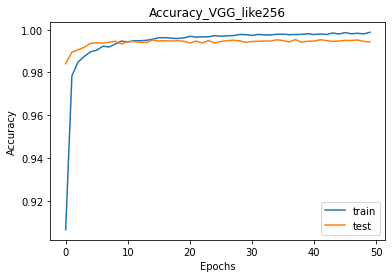

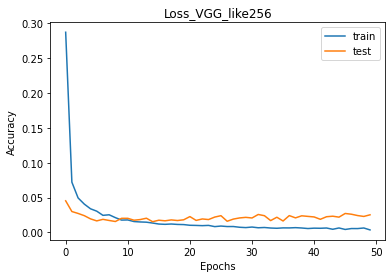

In [ ]:
# モデルの要約を表示
model_VGG_like256.summary()

# モデルを評価
print('\n正解率 =', score_VGG_like256[1], 'loss =', score_VGG_like256[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_VGG_like256.history['accuracy'])
plt.plot(hist_VGG_like256.history['val_accuracy'])
plt.title('Accuracy_VGG_like256')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

# ロスの推移プロット
plt.plot(hist_VGG_like256.history['loss'])
plt.plot(hist_VGG_like256.history['val_loss'])
plt.title('Loss_VGG_like256')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index1)
<a name="vgg6"></a>
### <a href="#vgg6">(5) Batch sizeの違いによるVGG_like結果比較</a>
MNISTの手書き数字データを利用したVGG-likeによる学習では、50 epochsに統一、batch sizeを32から256に増やし学習回数を稼いだ方が良い傾向が見られ、test_Accuracyの若干向上とtest_Lossの若干の減少が確認できた。


VGG_like32 正解率 = 0.9944000244140625 loss = 0.025489773601293564

VGG_like64 正解率 = 0.9945999979972839 loss = 0.025828594341874123

VGG_like128 正解率 = 0.9955000281333923 loss = 0.019897641614079475

VGG_like256 正解率 = 0.9952999949455261 loss = 0.01870587095618248


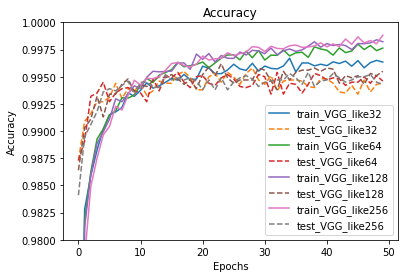

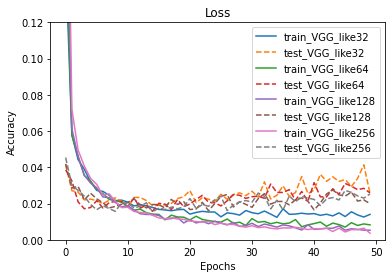

In [ ]:
# モデルを評価
print('\nVGG_like32', '正解率 =', score_VGG_like32[1], 'loss =', score_VGG_like32[0])
print('\nVGG_like64', '正解率 =', score_VGG_like64[1], 'loss =', score_VGG_like64[0])
print('\nVGG_like128', '正解率 =', score_VGG_like128[1], 'loss =', score_VGG_like128[0])
print('\nVGG_like256', '正解率 =', score_VGG_like256[1], 'loss =', score_VGG_like256[0])

# 学習の様子をグラフへ描画
# 正解率の推移プロット
plt.plot(hist_VGG_like32.history['accuracy'])
plt.plot(hist_VGG_like32.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_VGG_like64.history['accuracy'])
plt.plot(hist_VGG_like64.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_VGG_like128.history['accuracy'])
plt.plot(hist_VGG_like128.history['val_accuracy'], linestyle="dashed")
plt.plot(hist_VGG_like256.history['accuracy'])
plt.plot(hist_VGG_like256.history['val_accuracy'], linestyle="dashed")
plt.ylim(0.98,1.00)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_VGG_like32', 'test_VGG_like32', 
            'train_VGG_like64', 'test_VGG_like64',
            'train_VGG_like128', 'test_VGG_like128', 
            'train_VGG_like256', 'test_VGG_like256',], loc='lower right')
plt.show()

# ロスの推移プロット
plt.plot(hist_VGG_like32.history['loss'])
plt.plot(hist_VGG_like32.history['val_loss'], linestyle="dashed")
plt.plot(hist_VGG_like64.history['loss'])
plt.plot(hist_VGG_like64.history['val_loss'], linestyle="dashed")
plt.plot(hist_VGG_like128.history['loss'])
plt.plot(hist_VGG_like128.history['val_loss'], linestyle="dashed")
plt.plot(hist_VGG_like256.history['loss'])
plt.plot(hist_VGG_like256.history['val_loss'], linestyle="dashed")
plt.ylim(0,0.12)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_VGG_like32', 'test_VGG_like32', 
            'train_VGG_like64', 'test_VGG_like64',
            'train_VGG_like128', 'test_VGG_like128', 
            'train_VGG_like256', 'test_VGG_like256',], loc='best')
plt.show()

### [<div style="text-align: right;">↑</div>](#index2)
<a name="gui1"></a>
## <a href="#gui1">６. 手書き数字入力・予測GUIアプリケーションの作成</a> 
<a name="gui2"></a>
### <a href="#gui2">(1) 補正なし</a> 
 ① 左上キャンバスにマウスで左クリックしたままアラビア数字0-9をひとつ書く。\
 ② 左下の認識ボタンを左クリックする。\
 ③ 中央上のキャンパスに左上キャンバスに描画したイメージを28x28ピクセルに変換して表示される。これを正規化・白黒反転させて機械学習用に加工して読み込まれる。\
 ④ 右上のキャンバスに予測確率が一番高いアラビア数字が表示される。\
 ⑤ 右下のキャンバスには予測確率が高いTop3のらアラビア数字とその確率をパーセント表示される（赤文字が１番、青文字が２番、黒文字が３番）。\
 ⑥ 中央したのクリアボタンを左クリックするとすべての
 ＊ 学習済みモデルは汎化性能が１番高いVGG_likeのものをデフォルトで設定。

In [ ]:
# 必要なモジュールをインポート
import keras
from keras import backend as K
import numpy as np
import sys
import PIL
from PIL import Image, ImageTk, ImageDraw, ImageFilter
import tkinter as tk


# 入力画像の次元
img_rows, img_cols = 28, 28
# 学習済ファイルを読み込んでmodelを作成
savefile = 'numeral_VGG_like256_model.h5'
model = keras.models.load_model(savefile)


# GUIアプリケーションの内容
class Application(tk.Frame):
    
    # 初期化用関数
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.pack()
        self.w = 280 # 一つの描画領域の幅
        self.h = 280 # 一つの描画領域の高さ
        self.d = 20  # マウスで描画する際の一点の直径
        self.create_widgets()

        
    # GUI部品を構築
    def create_widgets(self):
        w = self.w
        h = self.h
        
        # マウスで描画するための領域
        self.canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.canvasを左端に配置
        self.canvas.grid(row=0, column=0)
        # self.canvasでマウスが動いた際にself.draw_digitが実行されるよう設定
        self.canvas.bind('<Button1-Motion>', self.draw_digit)

        # 認識用に用いる画像(self.canvasと共通化不能)
        self.img = Image.new('L', (w, h), color=1)
        # self.img上に描画するために必要なdraw
        self.draw = ImageDraw.Draw(self.img)

        # 認識用に self.img を加工して表示するキャンバス
        self.recog_canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.recog_canvas上に描画するための画像を生成して関連付け
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # self.canvasを中央に配置
        self.recog_canvas.grid(row=0, column=1)

        # 結果表示用のキャンバス
        self.digit_canvas = tk.Canvas(self, width=w, height=h, bg='gray')
        # self.digit_canvasを右端に配置
        self.digit_canvas.grid(row=0, column=2)
        
        # 予測確率用のキャンバス
        self.text_canvas = tk.Canvas(self, width=280, height=60, bg='white')
        # self.digit_canvasを右端に配置
        self.text_canvas.grid(row=1, column=2)

        # 認識ボタン
        self.recog_btn = tk.Button(self, text='認識', command=self.recog)
        # 認識ボタンを下段左に配置
        self.recog_btn.grid(row=1, column=0)
        # クリアボタン
        self.clear_btn = tk.Button(self, text='クリア', command=self.clear)
        # クリアボタンを下段右に配置
        self.clear_btn.grid(row=1, column=1)

        
    # 認識ボタンが押されたときに実行される関数
    def recog(self):
        w = self.w
        h = self.h
        # 描画されたイメージを28x28のrecog_imgに縮小
        recog_img = self.img
        recog_img = recog_img.resize(size=(28,28), resample=Image.BICUBIC)
        
        # (28,28)のrecog_imgを描画用に拡大
        recog_img_large = recog_img.resize(size=(w, h), resample=0)
        self.recog_img = ImageTk.PhotoImage(image=recog_img_large)
        self.recog_canvas.create_image((w/2, h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        
        # 28x28の画像を機械学習用に加工
        Ximg = np.asarray(recog_img, dtype=int)
        # 正規化（最大値１にする）
        Ximg = Ximg / 255.0
        # 白黒反転
        Ximg = 1 - Ximg
        # 機械学習用データの完成
        X = np.array([Ximg.flatten()])
        
        # Xをkeras用のデータ形式に変換
        if K.image_data_format() == 'channels_first':
            X = X.reshape(X.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X = X.reshape(X.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
        # kerasによる予測
        y1 = model.predict_classes(X, verbose=0)
        # kerasによるクラス予測の確率
        y2 = model.predict(X, verbose=0)
        # 予測結果を右の領域の表示
        self.digit_canvas.create_text(w/2, h/2, text='{0:d}'.format(y1[0]),
                                      fill='white', font = ('FixedSys', int(w/2)))
        
        # 予測結果をパーセント表示
        y2_percent = (y2*100).astype('int32')
        # 確率が高い順にインデックスを並び替える
        y2_argsort = y2.argsort()[:, ::-1]
        
        # 予測結果の確率を右下に表示(赤字：予測確率が１番高い数字、青：予測確率が２番目に高い数字、黒：予測確率が三番目に高い数字)
        self.text_canvas.create_text(140, 10,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 0], y2_percent[0, y2_argsort[0, 0]]),
            fill='red', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 30,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 1], y2_percent[0, y2_argsort[0, 1]]),
            fill='blue', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 50,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 2], y2_percent[0, y2_argsort[0, 2]]),
            fill='black', font = ('FixedSys', 10))

        
    # クリアボタンが押されたときに実行される関数
    def clear(self):
        w = self.w
        h = self.h
        # 左の描画領域をクリア
        self.canvas.delete('all')
        self.draw.rectangle(xy=[0,0,w,h], 
                            outline='white', fill='white')
        # 中央の認識領域をクリア
        self.recog_canvas.delete('all')
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # 右の結果表示領域をクリア
        self.digit_canvas.delete('all')
        # 右下の予測確率の表示領域をクリア
        self.text_canvas.delete('all')

        
    # 左側の描画領域でマウスが動いたときに呼ばれる関数
    def draw_digit(self, event):
        d = self.d
        x = event.x
        y = event.y
        # 描画領域に黒丸を描画
        id = self.canvas.create_oval(x-d/2, y-d/2, x+d/2, y+d/2)
        self.canvas.itemconfigure(id, fill='black')
        # 認識用の画像に黒丸を描画
        self.draw.ellipse(xy=[x-d/2, y-d/2, x+d/2, y+d/2], fill=0, outline=0) 

        
root = tk.Tk()
app = Application(master=root)
app.master.title('手書き数字入力・予測GUIアプリ')
app.mainloop()

### [<div style="text-align: right;">↑</div>](#index2)
<a name="gui3"></a>
### <a href="#gui3">(2) 位置＋サイズ補正あり</a> 
　手入力したアラビア数字の中心位置をキャンバスの中央へ、適切なサイズに拡大縮小するように補正させたGUIアプリである。このことにより入力キャンバス中心から大きくずれた数字や、小さすぎるもしくは大きすぎる入力数字の認識・予測精度が向上した。
 
  このサイズの補正の際に280×280ピクセルのキャンバスに対して、周囲40ピクセルの余白を最低でも設けるように拡大縮小させるように調整している。つまり、中心を揃えた200×200ピクセルのキャンバスとして拡大縮小させている。この余白が小さすぎると「９」の予測精度が著しく低下して、「７」「４」「１」「２」と誤認するようになった。後ほど示す。

In [ ]:
# 必要なモジュールをインポート
import keras
from keras import backend as K
import numpy as np
import sys
import PIL
from PIL import Image, ImageTk, ImageDraw, ImageFilter
import tkinter as tk


# 入力画像の次元
img_rows, img_cols = 28, 28
# 学習済ファイルを読み込んでmodelを作成
savefile = 'numeral_VGG_like256_model.h5' 
model = keras.models.load_model(savefile)



# 以下はGUIアプリケーション用の内容
class Application(tk.Frame):
    
    # 初期化用関数
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.pack()
        self.w = 280 # 一つの描画領域の幅
        self.h = 280 # 一つの描画領域の高さ
        self.d = 20  # マウスで描画する際の一点の直径
        self.drawxmin = self.w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0       # 描画のxの最大座標（補正用）
        self.drawymin = self.h  # 描画のyの最小座標（補正用）
        self.drawymax = 0       # 描画のyの最大座標（補正用）
        self.create_widgets()

        
    # 様々なGUI部品を構築
    def create_widgets(self):
        w = self.w
        h = self.h
        # マウスで描画するための領域
        self.canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.canvasを左端に配置
        self.canvas.grid(row=0, column=0)
        # self.canvasでマウスが動いた際にself.draw_digitが実行されるよう設定
        self.canvas.bind('<Button1-Motion>', self.draw_digit)

        # 認識用に用いる画像(self.canvasと共通化不能)
        self.img = Image.new('L', (w, h), color=255)
        # self.img上に描画するために必要なdraw
        self.draw = ImageDraw.Draw(self.img)

        # 認識用に self.img を加工して表示するキャンバス
        self.recog_canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.recog_canvas上に描画するための画像を生成して関連付け
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # self.canvasを中央に配置
        self.recog_canvas.grid(row=0, column=1)

        # 結果表示用のキャンバス
        self.digit_canvas = tk.Canvas(self, width=w, height=h, bg='gray')
        # self.digit_canvasを右端に配置
        self.digit_canvas.grid(row=0, column=2)
        
        # 予測確率用のキャンバス
        self.text_canvas = tk.Canvas(self, width=280, height=60, bg='white')
        # self.digit_canvasを右端に配置
        self.text_canvas.grid(row=1, column=2)

        # 認識ボタン
        self.recog_btn = tk.Button(self, text='認識', command=self.recog)
        # 認識ボタンを下段左に配置
        self.recog_btn.grid(row=1, column=0)
        # クリアボタン
        self.clear_btn = tk.Button(self, text='クリア', command=self.clear)
        # クリアボタンを下段右に配置
        self.clear_btn.grid(row=1, column=1)

        
    # 認識ボタンが押されたときに実行される関数
    def recog(self):
        w = self.w
        h = self.h
        
        # 描画されたイメージを28x28のrecog_imgに縮小
        # 描画された数字を切り出し、認識エリア内中心に拡大する
        if self.drawxmin < self.drawxmax and self.drawymin < self.drawymax:
            recog_img = Image.new('L', (w, h), color=255)
            if self.drawxmax - self.drawxmin >= self.drawymax - self.drawymin:
                hr = int((self.drawymax - self.drawymin)*(self.w-80) / (self.drawxmax - self.drawxmin))
                h0 = int((h - hr) / 2)
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                tmp_img = tmp_img.resize(size=(w-80, hr), resample=Image.BICUBIC)
                recog_img.paste(tmp_img, (40, h0, self.w-40, h0+hr))
            else:
                wr = int((self.drawxmax - self.drawxmin)*(self.h-80) / (self.drawymax - self.drawymin))
                w0 = int((w-wr)/2)
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                tmp_img = tmp_img.resize(size=(wr, h-80), resample=Image.BICUBIC)
                recog_img.paste(tmp_img, (w0, 40, w0+wr,self.h-40))
        else:
            recog_img = self.img
        # 位置と大きさを補正されたイメージを28x28のrecog_imgに縮小
        recog_img = recog_img.resize(size=(28,28), resample=Image.BICUBIC)

        # (28,28)のrecog_imgを描画用に拡大
        recog_img_large = recog_img.resize(size=(w, h), resample=0)
        self.recog_img = ImageTk.PhotoImage(image=recog_img_large)
        self.recog_canvas.create_image((w/2, h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img

        # 28x28の画像を機械学習用に加工
        Ximg = np.asarray(recog_img, dtype=int)
        # 正規化（最大値を１にする）
        Ximg = Ximg / 255.0
        # 白黒反転
        Ximg = 1 - Ximg
        # 機械学習用データの完成
        X = np.array([Ximg.flatten()])
        # Xをkeras用のデータ形式に変換
        if K.image_data_format() == 'channels_first':
            X = X.reshape(X.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X = X.reshape(X.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
        # kerasによるクラス予測
        y1 = model.predict_classes(X, verbose=0)
        # kerasによるクラス予測の確率
        y2 = model.predict(X, verbose=0)
        # 予測結果を右の領域の表示
        self.digit_canvas.create_text(w/2, h/2, text = '{0:d}'.format(y1[0]),
                                      fill='white', font = ('FixedSys', int(w/2)))
        
        # 予測結果をパーセント表示
        y2_percent = (y2*100).astype('int32')
        # 確率が高い順にインデックスを並び替える
        y2_argsort = y2.argsort()[:, ::-1]
        
        # 予測結果の確率を右下に表示(赤字：予測確率が１番高い数字、青：予測確率が２番目に高い数字、黒：予測確率が三番目に高い数字)
        self.text_canvas.create_text(140, 10,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 0], y2_percent[0, y2_argsort[0, 0]]),
            fill='red', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 30,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 1], y2_percent[0, y2_argsort[0, 1]]),
            fill='blue', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 50,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 2], y2_percent[0, y2_argsort[0, 2]]),
            fill='black', font = ('FixedSys', 10))

        
    # クリアボタンが押されたときに実行される関数
    def clear(self):
        w = self.w
        h = self.h
        # 左の描画領域をクリア
        self.canvas.delete('all')
        self.draw.rectangle(xy=[0,0,w,h], outline='white', fill='white')
        # 中央の認識領域をクリア
        self.recog_canvas.delete('all')
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # 右の結果表示領域をクリア
        self.digit_canvas.delete('all')
        # 右下の予測確率の表示領域をクリア
        self.text_canvas.delete('all')
        # 描画の座標の最小値と最大値をクリア
        self.drawxmin = w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0  # 描画のxの最大座標（補正用）
        self.drawymin = h  # 描画のyの最小座標（補正用）
        self.drawymax = 0  # 描画のyの最大座標（補正用）

    # 左側の描画領域でマウスが動いたときに呼ばれる関数
    def draw_digit(self, event):
        d = self.d
        x = event.x
        y = event.y
        # 描画領域に黒丸を描画
        id = self.canvas.create_oval(x-d/2, y-d/2, x+d/2, y+d/2)
        self.canvas.itemconfigure(id, fill='black')
        # 認識用の画像に黒丸を描画
        self.draw.ellipse(xy=[x-d/2, y-d/2, x+d/2, y+d/2], fill=0, outline=0) 
        # 描画最小座標と最大座標を更新
        if x-d/2 < self.drawxmin:
            self.drawxmin = max(x-d/2, 0)
        if x+d/2 > self.drawxmax:
            self.drawxmax = min(x+d/2, self.w)
        if y-d/2 < self.drawymin:
            self.drawymin = max(y-d/2, 0)
        if y+d/2 > self.drawymax:
            self.drawymax = min(y+d/2, self.h)

            
root = tk.Tk()
app = Application(master=root)
app.master.title('手書き数字入力・予測GUIアプリ（位置・サイズ補正）')
app.mainloop()

TclError: ignored

### [<div style="text-align: right;">↑</div>](#index2)
<a name="gui4"></a>
### <a href="#gui4">(３) 補正失敗</a> 
　このサイズの補正の際に280×280ピクセルのキャンバスに対して、周囲10ピクセルの余白を最低でも設けるように拡大縮小させるように調整した。つまり、中心を揃えた260×260ピクセルのキャンバスとして拡大縮小させた。

In [ ]:
# 必要なモジュールをインポート
import keras
from keras import backend as K
import numpy as np
import sys
import PIL
from PIL import Image, ImageTk, ImageDraw, ImageFilter
import tkinter as tk


# 入力画像の次元
img_rows, img_cols = 28, 28
# 学習済ファイルを読み込んでmodelを作成
savefile = 'numeral_VGG_like256_model.h5' 
model = keras.models.load_model(savefile)



# 以下はGUIアプリケーション用の内容
class Application(tk.Frame):
    
    # 初期化用関数
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.pack()
        self.w = 280 # 一つの描画領域の幅
        self.h = 280 # 一つの描画領域の高さ
        self.d = 20  # マウスで描画する際の一点の直径
        self.drawxmin = self.w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0       # 描画のxの最大座標（補正用）
        self.drawymin = self.h  # 描画のyの最小座標（補正用）
        self.drawymax = 0       # 描画のyの最大座標（補正用）
        self.create_widgets()

        
    # 様々なGUI部品を構築
    def create_widgets(self):
        w = self.w
        h = self.h
        # マウスで描画するための領域
        self.canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.canvasを左端に配置
        self.canvas.grid(row=0, column=0)
        # self.canvasでマウスが動いた際にself.draw_digitが実行されるよう設定
        self.canvas.bind('<Button1-Motion>', self.draw_digit)

        # 認識用に用いる画像(self.canvasと共通化不能)
        self.img = Image.new('L', (w, h), color=255)
        # self.img上に描画するために必要なdraw
        self.draw = ImageDraw.Draw(self.img)

        # 認識用に self.img を加工して表示するキャンバス
        self.recog_canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.recog_canvas上に描画するための画像を生成して関連付け
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # self.canvasを中央に配置
        self.recog_canvas.grid(row=0, column=1)

        # 結果表示用のキャンバス
        self.digit_canvas = tk.Canvas(self, width=w, height=h, bg='gray')
        # self.digit_canvasを右端に配置
        self.digit_canvas.grid(row=0, column=2)
        
        # 予測確率用のキャンバス
        self.text_canvas = tk.Canvas(self, width=280, height=60, bg='white')
        # self.digit_canvasを右端に配置
        self.text_canvas.grid(row=1, column=2)

        # 認識ボタン
        self.recog_btn = tk.Button(self, text='認識', command=self.recog)
        # 認識ボタンを下段左に配置
        self.recog_btn.grid(row=1, column=0)
        # クリアボタン
        self.clear_btn = tk.Button(self, text='クリア', command=self.clear)
        # クリアボタンを下段右に配置
        self.clear_btn.grid(row=1, column=1)

        
    # 認識ボタンが押されたときに実行される関数
    def recog(self):
        w = self.w
        h = self.h
        
        # 描画されたイメージを28x28のrecog_imgに縮小
        # 描画された数字を切り出し、認識エリア内中心に拡大する
        if self.drawxmin < self.drawxmax and self.drawymin < self.drawymax:
            recog_img = Image.new('L', (w, h), color=255)
            if self.drawxmax - self.drawxmin >= self.drawymax - self.drawymin:
                hr = int((self.drawymax - self.drawymin)*(self.w-20) / (self.drawxmax - self.drawxmin))
                h0 = int((h - hr) / 2)
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                tmp_img = tmp_img.resize(size=(w-20, hr), resample=Image.BICUBIC)
                recog_img.paste(tmp_img, (10, h0, self.w-10, h0+hr))
            else:
                wr = int((self.drawxmax - self.drawxmin)*(self.h-20) / (self.drawymax - self.drawymin))
                w0 = int((w-wr)/2)
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                tmp_img = tmp_img.resize(size=(wr, h-20), resample=Image.BICUBIC)
                recog_img.paste(tmp_img, (w0, 10, w0+wr,self.h-10))
        else:
            recog_img = self.img
        # 位置と大きさを補正されたイメージを28x28のrecog_imgに縮小
        recog_img = recog_img.resize(size=(28,28), resample=Image.BICUBIC)

        # (28,28)のrecog_imgを描画用に拡大
        recog_img_large = recog_img.resize(size=(w, h), resample=0)
        self.recog_img = ImageTk.PhotoImage(image=recog_img_large)
        self.recog_canvas.create_image((w/2, h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img

        # 28x28の画像を機械学習用に加工
        Ximg = np.asarray(recog_img, dtype=int)
        # 正規化（最大値を１にする）
        Ximg = Ximg / 255.0
        # 白黒反転
        Ximg = 1 - Ximg
        # 機械学習用データの完成
        X = np.array([Ximg.flatten()])
        # Xをkeras用のデータ形式に変換
        if K.image_data_format() == 'channels_first':
            X = X.reshape(X.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X = X.reshape(X.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
        # kerasによるクラス予測
        y1 = model.predict_classes(X, verbose=0)
        # kerasによるクラス予測の確率
        y2 = model.predict(X, verbose=0)
        # 予測結果を右の領域の表示
        self.digit_canvas.create_text(w/2, h/2, text = '{0:d}'.format(y1[0]),
                                      fill='white', font = ('FixedSys', int(w/2)))
        
        # 予測結果をパーセント表示
        y2_percent = (y2*100).astype('int32')
        # 確率が高い順にインデックスを並び替える
        y2_argsort = y2.argsort()[:, ::-1]
        
        # 予測結果の確率を右下に表示(赤字：予測確率が１番高い数字、青：予測確率が２番目に高い数字、黒：予測確率が三番目に高い数字)
        self.text_canvas.create_text(140, 10,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 0], y2_percent[0, y2_argsort[0, 0]]),
            fill='red', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 30,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 1], y2_percent[0, y2_argsort[0, 1]]),
            fill='blue', font = ('FixedSys', 10))
        self.text_canvas.create_text(140, 50,
            text = '予測した数字 {0} : {1} %'.format(y2_argsort[0, 2], y2_percent[0, y2_argsort[0, 2]]),
            fill='black', font = ('FixedSys', 10))

        
    # クリアボタンが押されたときに実行される関数
    def clear(self):
        w = self.w
        h = self.h
        # 左の描画領域をクリア
        self.canvas.delete('all')
        self.draw.rectangle(xy=[0,0,w,h], outline='white', fill='white')
        # 中央の認識領域をクリア
        self.recog_canvas.delete('all')
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # 右の結果表示領域をクリア
        self.digit_canvas.delete('all')
        # 右下の予測確率の表示領域をクリア
        self.text_canvas.delete('all')
        # 描画の座標の最小値と最大値をクリア
        self.drawxmin = w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0  # 描画のxの最大座標（補正用）
        self.drawymin = h  # 描画のyの最小座標（補正用）
        self.drawymax = 0  # 描画のyの最大座標（補正用）

    # 左側の描画領域でマウスが動いたときに呼ばれる関数
    def draw_digit(self, event):
        d = self.d
        x = event.x
        y = event.y
        # 描画領域に黒丸を描画
        id = self.canvas.create_oval(x-d/2, y-d/2, x+d/2, y+d/2)
        self.canvas.itemconfigure(id, fill='black')
        # 認識用の画像に黒丸を描画
        self.draw.ellipse(xy=[x-d/2, y-d/2, x+d/2, y+d/2], fill=0, outline=0) 
        # 描画最小座標と最大座標を更新
        if x-d/2 < self.drawxmin:
            self.drawxmin = max(x-d/2, 0)
        if x+d/2 > self.drawxmax:
            self.drawxmax = min(x+d/2, self.w)
        if y-d/2 < self.drawymin:
            self.drawymin = max(y-d/2, 0)
        if y+d/2 > self.drawymax:
            self.drawymax = min(y+d/2, self.h)

            
root = tk.Tk()
app = Application(master=root)
app.master.title('手書き数字入力・予測GUIアプリ（補正失敗）')
app.mainloop()